# F6, S10, S12: Recurrence of clusters

# Init and load data

In [1]:
import sys
sys.path.append('../../')
from global_variables import SUBDIR, RUN, WORKSPACE, HOME, SUBDIR_CH, RUN_CH
import socket
print("Working node:", socket.gethostname())

Working node: irbccn38.hpc.irbbarcelona.pcb.ub.es


In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import os
import numpy as np
import json
import re
from matplotlib.colors import LinearSegmentedColormap

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
## O3D RUN
input_path = f"{WORKSPACE}/projects/clustering_3d/o3d_analysys/datasets/input/cancer_202404"
cohort_df = pd.read_csv(f"{input_path}/cohorts.tsv", sep="\t")
cohort_df = cohort_df[~cohort_df.COHORT.str.startswith("ICGC")].reset_index(drop=True)
oncotree_df = pd.read_csv(f"{input_path}/oncotree.tsv", sep="\t")
datasets = f"{WORKSPACE}/projects/clustering_3d/o3d_analysys/datasets/output"
o3d_output_dir = f"{datasets}/cancer_202404/o3d_output/human_mane_raw/{RUN}"

## O3D DATA

# General
o3d_datasets = f"{WORKSPACE}/nobackup/scratch/oncodrive3d/datasets_mane_240506"
o3d_annotations = f"{WORKSPACE}/nobackup/scratch/oncodrive3d/annotations_mane_240506"
o3d_seq_df = pd.read_table(f"{o3d_datasets}/seq_for_mut_prob.tsv")
o3d_annot_df = pd.read_table(f"{o3d_annotations}/uniprot_feat.tsv")
o3d_pdb_tool_df = pd.read_table(f"{o3d_annotations}/pdb_tool_df.tsv")
disorder_df = pd.read_table(f"{o3d_datasets}/confidence.tsv")
o3d_datasets_canonical = f"{WORKSPACE}/nobackup/scratch/oncodrive3d/datasets_240506"
o3d_seq_df_canonical = pd.read_table(f"{o3d_datasets_canonical}/seq_for_mut_prob.tsv")

## Genes annot
uniq_drivers_df = pd.read_table(f"{input_path}/unique_drivers.tsv")
cgc_df = pd.read_csv(f"{input_path}/CGC_list_v99.tsv", sep = "\t")
oncokb_df = pd.read_csv(f"{input_path}/oncokb_list_20240712.tsv", sep = "\t")

cgc_genes = cgc_df["Gene Symbol"].unique()
intogen_genes = uniq_drivers_df.SYMBOL.unique()
oncokb_genes = oncokb_df["Hugo Symbol"].unique()

genetable_path = f"{WORKSPACE}/projects/clustering_3d/o3d_analysys/o3d_paper/notebooks/0.genetables/results/{SUBDIR}/{RUN}.genetable.tsv"
genetable = pd.read_csv(genetable_path, sep="\t")
genetable = genetable[[not cohort.startswith("ICGC") for cohort in genetable["Cohort"]]].reset_index(drop=True)
hotmaps_genes = genetable[genetable["hotmaps_qval"] < 0.01].Gene.unique()

## Others
degmd = f"{HOME}/spellegrini/degrons/degronmd/Predicte_degrons_properties.tsv.gz"   # Predicted + known degrons from DegonMD
degmd = pd.read_csv(degmd, sep="\t")
degmd

/tmp/ipykernel_2623022/1870087116.py:16: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  o3d_pdb_tool_df = pd.read_table(f"{o3d_annotations}/pdb_tool_df.tsv")
/tmp/ipykernel_2623022/1870087116.py:17: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  disorder_df = pd.read_table(f"{o3d_datasets}/confidence.tsv")


,Entry,Entry_Isoform,DEGRON,START,END,ASA_SCORE,CONS_SCORE,FCONS_SCORE,COIL,HELIX,...,Hit,Annotated,Database,E3,Prob_DEGRON,Prob_RANDOM,Predicted_Class,Min_Class,Class,Class_DEGRON_threshold
0,A0A087X1C5,A0A087X1C5,DEG_APCC_DBOX_1,220,228,0.000000,0.000000,0.000000,0.000000,0.000000,...,LREVLNAVP,NO,Predicted,"APC,CDC20,FZR1",0.024823,0.975177,0,0.985877,NON-DEGRON,Motif match
1,A0A087X1C5,A0A087X1C5,DEG_SPOP_SBC_1,308,312,0.000000,0.000000,0.000000,0.000000,0.000000,...,VTTST,NO,Predicted,SPOP,0.024823,0.975177,0,0.919203,NON-DEGRON,Motif match
2,A0A087X1C5,A0A087X1C5,LIG_APCC_ABBA_1,321,326,0.000000,0.000000,0.000000,0.000000,0.000000,...,MILHLD,NO,Predicted,"APC,CDC20,FZR1",0.024823,0.975177,0,0.959828,NON-DEGRON,Motif match
3,A0A0B4J2F2,A0A0B4J2F2,DEG_APCC_DBOX_1,470,478,0.000000,0.000000,0.000000,0.000000,0.000000,...,RRHTLAEVS,NO,Predicted,"APC,CDC20,FZR1",0.035229,0.964771,0,0.985877,NON-DEGRON,Motif match
4,A0A0C5B5G6,A0A0C5B5G6,DEG_APCC_TPR_1,14,16,0.000000,0.000000,0.000000,0.000000,0.000000,...,KLR,NO,Predicted,"APC,CDC20,FZR1",0.035229,0.964771,0,0.966761,NON-DEGRON,Motif match
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53286,Q9UF83,Q9UF83,DEG_APCC_DBOX_1,296,304,107.377778,0.382684,0.968748,0.930111,0.049111,...,SRASLMKME,NO,Predicted,"APC,CDC20,FZR1",0.973176,0.026824,1,0.985877,NON-DEGRON,Novel instance
53287,Q9UF83,Q9UF83,DEG_SCF_FBW7_2,178,185,113.287500,0.365005,0.959331,0.974000,0.010500,...,PTRTPPRE,NO,Predicted,FBXW7,0.949765,0.050235,1,0.998569,NON-DEGRON,Novel instance
53288,Q9UF83,Q9UF83,DEG_SCF_FBW7_2,213,220,113.587500,0.367393,0.916879,0.963500,0.022500,...,PTRTPPRE,NO,Predicted,FBXW7,0.934346,0.065654,1,0.998569,NON-DEGRON,Novel instance
53289,Q9UF83,Q9UF83,DEG_SCF_FBW7_2,554,561,95.700000,0.408822,1.126794,0.969875,0.017375,...,PASTPSSE,NO,Predicted,FBXW7,0.933086,0.066914,1,0.998569,NON-DEGRON,Novel instance


# Get data

In [4]:
# Get only result from genes that were detected as significant in the cohort
def get_o3d_result(cohorts, o3d_output_dir):

    lst_dfs = []

    for cohort in cohorts:
        cohort = "TCGA_WXS_SOFT_TISSUE" if cohort == "TCGA_WXS_SARC" else cohort
        
        path_csv = f"{o3d_output_dir}/{cohort}/{cohort}.3d_clustering_pos.csv"
        path_genes_csv = f"{o3d_output_dir}/{cohort}/{cohort}.3d_clustering_genes.csv"
        if os.path.exists(path_csv) and os.path.exists(path_genes_csv):

            # Get detected genes
            df_genes_cohort = pd.read_csv(path_genes_csv)
            df_genes_cohort = df_genes_cohort[df_genes_cohort["C_gene"] == 1] 
            genes_detected = df_genes_cohort.apply(lambda x: x.Gene, axis=1).values

            if len(genes_detected) > 0:
                # Get per-residue result
                df_cohort = pd.read_csv(path_csv)
                cols = ["Gene", "Uniprot_ID", "F", "Pos", "Mut_in_gene", "Score_obs_sim", "C", "C_ext", 'Cancer', 'Cohort'] #"Mut_in_res", "Mut_in_vol", "pval"
                df_cohort = df_cohort.loc[df_cohort.Gene.isin(genes_detected), cols]
                lst_dfs.append(df_cohort)
                
        else:
            print(f"Path doesn't exist: {path_csv}")

    return pd.concat(lst_dfs)

o3d_pos_result = get_o3d_result(cohort_df["COHORT"].values, o3d_output_dir)
o3d_pos_result

/tmp/ipykernel_2623022/495394011.py:20: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_cohort = pd.read_csv(path_csv)


Path doesn't exist: /data/bbg/projects/clustering_3d/o3d_analysys/datasets/output/cancer_202404/o3d_output/human_mane_raw/run_2024-07-01_16-04-14/PEDCBIOP_WXS_TALL_REL/PEDCBIOP_WXS_TALL_REL.3d_clustering_pos.csv


,Gene,Uniprot_ID,F,Pos,Mut_in_gene,Score_obs_sim,C,C_ext,Cancer,Cohort
1047,FBXW7,Q969H0,1,505,8,3.204794,1,0.0,NaN,HARTWIG_WGS_BLCA_2023
1048,FBXW7,Q969H0,1,465,8,3.409612,1,0.0,NaN,HARTWIG_WGS_BLCA_2023
1049,FBXW7,Q969H0,1,176,8,0.410806,0,NaN,NaN,HARTWIG_WGS_BLCA_2023
1050,FBXW7,Q969H0,1,280,8,0.390281,0,NaN,NaN,HARTWIG_WGS_BLCA_2023
1057,FGFR3,P22607,1,248,17,4.734346,1,0.0,NaN,HARTWIG_WGS_BLCA_2023
...,...,...,...,...,...,...,...,...,...,...
1,EPAS1,Q99814,1,531,8,5.687067,1,0.0,NaN,TCGA_WXS_PGNG
2,EPAS1,Q99814,1,530,8,6.057751,1,0.0,NaN,TCGA_WXS_PGNG
3,EPAS1,Q99814,1,532,8,6.386988,1,0.0,NaN,TCGA_WXS_PGNG
5,HRAS,P01112,1,13,18,7.463746,1,0.0,NaN,TCGA_WXS_PGNG


In [5]:
# I could start plotting from the genes that is either detected across more cohorts or that has clusters across more cohorts

# Sort by number of cohorts with at least one cluster
display(o3d_pos_result.groupby("Gene").apply(lambda x: len(x[x["C"] == 1].Cohort.unique())).sort_values(ascending=False)[:40])
genes_order = o3d_pos_result.groupby("Gene").apply(lambda x: len(x[x["C"] == 1].Cohort.unique())).sort_values(ascending=False)

Gene
TP53        66
PIK3CA      35
KRAS        33
CTNNB1      19
BRAF        18
NRAS        16
SMAD4       10
SPOP        10
NFE2L2      10
FBXW7        9
SF3B1        9
EGFR         9
IDH1         8
HRAS         7
FGFR3        6
MED12        6
ERBB2        5
FOXA1        5
PTEN         5
PTPN11       4
SMARCA4      4
EZH2         4
MYD88        4
AR           4
AKT1         3
SMO          3
CREBBP       3
GNAS         3
CDKN2A       3
U2AF1        3
ALK          3
HLA-DQA1     3
RAC1         3
KIT          3
PPP6C        3
IDH2         3
PPP2R1A      3
XPO1         3
LILRB2       2
ERBB3        2
dtype: int64

In [6]:
dict_prob_cohorts = {}
o3d_dict = {}
for gene in o3d_pos_result.Gene.unique(): 
    print(gene)
    o3d_dict[gene] = {}
    for cohort in o3d_pos_result[o3d_pos_result["Gene"] == gene].Cohort.unique():
        o3d_gene_cohort = o3d_pos_result.loc[(o3d_pos_result["Gene"] == gene) & (o3d_pos_result["Cohort"] == cohort)]
        o3d_dict[gene][cohort] = {}
        o3d_dict[gene][cohort]["Result"] = o3d_gene_cohort
        uni_id, af_f = o3d_gene_cohort[["Uniprot_ID", "F"]].drop_duplicates().values[0]
        
        if cohort not in dict_prob_cohorts:
            prob_dict_cohort_path = f"{o3d_output_dir}/{cohort}/{cohort}.miss_prob.processed.json"
            with open(prob_dict_cohort_path, 'r') as file:
                dict_prob_cohorts[cohort] = json.load(file)
        
        o3d_dict[gene][cohort]["Prob"] = dict_prob_cohorts[cohort][f"{uni_id}-F{af_f}"]

FBXW7
FGFR3
PIK3CA
RXRA
TP53
BRAF
CTAGE6
CTNNA2
NBPF3
NRAS
PPP6C
ZNF804A
CUX2
FAM186A
CTNNB1
BCL9L
ERBB2
ERBB3
KRAS
PCBP1
SMAD4
EGFR
SPOP
KIT
G3BP1
SF3B1
IKZF3
IRF4
MED12
MYD88
XPO1
ALK
U2AF1
UGT2B17
ADH4
CNOT9
CRNKL1
IDH1
KNSTRN
MAP2K1
RAC1
ZFX
EZH2
MEF2C
CREM
ITPRID2
IFITM3
HRAS
PPP1R13L
CD79B
POU2F2
AKT1
ESR1
FOXA1
MADCAM1
NOTCH2
ZNF83
BCOR
NFE2L2
PPP2R1A
PTEN
ANKAR
TRIO
ANKRD36
FAM8A1
HLA-A
HLA-DQA1
HLA-DRB5
KIR2DL1
LILRB2
MUC17
BAP1
VHL
CDKN2A
RETSAT
CSMD2
KDR
PLCG1
ZNF430
AR
AHNAK
ANKRD30A
ERBB4
SPDYE5
TMPRSS13
ZAN
FMN2
TLL1
NSD2
PTPN11
ANK2
ANKMY1
ASPM
GOLGA3
MYCN
TEX15
TNFAIP2
FOXO1
ID3
OR5H14
ATG2A
EPPK1
ESX1
PER3
TMEM14B
ZNF880
AHNAK2
BMP6
FAM180B
OR5F1
PLXNB1
RALGAPA1
SEL1L2
UNC93B1
USP7
ZNF646
ZNF780B
KRTAP13-3
ALOX15
ARHGAP5
BMP2K
CCND1
DIS3
EFTUD2
EGR1
FOXD4L1
H1-5
HNRNPU
IGLL5
IKBKB
IVL
KLHL6
MAX
ODAD2
PANK3
PRKD2
RPL10
RPS3A
SIGLEC10
TGFB1
TRIM73
USP8
ZNF395
APOBR
CREBBP
MEF2B
SGK1
STAT3
FAM174B
GBP4
H3-3A
HLA-DQB1
KMT2D
SIRPA
SMARCA4
SMO
TBR1
TIPIN
KDM6A
RIMS4
ADGRV1
E

## Missense mut

In [7]:
lst_gene_cohort = []
for gene in o3d_dict.keys():
    for cohort in o3d_dict[gene].keys():
        lst_gene_cohort.append((cohort, gene))
gene_cohort_df = pd.DataFrame(lst_gene_cohort, columns=["Cohort", "Gene"])
gene_cohort_df = gene_cohort_df.groupby("Cohort")["Gene"].agg(list).reset_index()
gene_cohort_df

,Cohort,Gene
0,CBIOP_WGS_PRAD_EURUROL_2017,[SPOP]
1,CBIOP_WGS_STAD_ONCOSG_2018,[TP53]
2,CBIOP_WXS_ACY_2019,"[NOTCH2, RETSAT]"
3,CBIOP_WXS_ANGS_TREATED_2020,[G3BP1]
4,CBIOP_WXS_ANGS_UNTREAT_2020,"[CSMD2, KDR, PLCG1, ZNF430]"
...,...,...
130,TCGA_WXS_THYM,[GTF2I]
131,TCGA_WXS_UCEC,"[FBXW7, PIK3CA, TP53, NRAS, CTNNB1, ERBB3, KRA..."
132,TCGA_WXS_UCS,"[FBXW7, TP53, PPP2R1A]"
133,TCGA_WXS_UM,"[SF3B1, GNA11, GNAQ]"


In [8]:
lst_missense_df = []
for cohort, genes in gene_cohort_df[["Cohort", "Gene"]].values:
    cohort_missense_df = pd.read_table(f"{o3d_output_dir}/{cohort}/{cohort}.mutations.processed.tsv")
    cohort_missense_df = cohort_missense_df[cohort_missense_df["Gene"].isin(genes)].reset_index(drop=True)
    cohort_missense_df["Cohort"] = cohort
    lst_missense_df.append(cohort_missense_df)

missense_df = pd.concat(lst_missense_df)
display(missense_df)

missense_count_df = missense_df.groupby(['Gene', 'Pos']).size().reset_index(name='Count')

,Gene,Pos,WT,Mut,Transcript_ID,O3D_transcript_ID,Transcript_status,Cohort
0,SPOP,87,Y,C,ENST00000504102,ENST00000504102,Match,CBIOP_WGS_PRAD_EURUROL_2017
1,SPOP,102,F,C,ENST00000504102,ENST00000504102,Match,CBIOP_WGS_PRAD_EURUROL_2017
2,SPOP,102,F,C,ENST00000504102,ENST00000504102,Match,CBIOP_WGS_PRAD_EURUROL_2017
3,SPOP,102,F,C,ENST00000504102,ENST00000504102,Match,CBIOP_WGS_PRAD_EURUROL_2017
4,SPOP,102,F,Y,ENST00000504102,ENST00000504102,Match,CBIOP_WGS_PRAD_EURUROL_2017
...,...,...,...,...,...,...,...,...
338,NRAS,61,Q,K,ENST00000369535,ENST00000369535,Match,TCGA_WXS_WDTC
339,NRAS,61,Q,K,ENST00000369535,ENST00000369535,Match,TCGA_WXS_WDTC
340,NRAS,61,Q,K,ENST00000369535,ENST00000369535,Match,TCGA_WXS_WDTC
341,NRAS,61,Q,K,ENST00000369535,ENST00000369535,Match,TCGA_WXS_WDTC


In [9]:
# Predicted + known degrons
degmd_pred = f"{HOME}/spellegrini/degrons/degronmd/Predicte_degrons_properties.tsv.gz"
degmd_pred = pd.read_csv(degmd_pred, sep="\t").rename(columns={"START" : "Begin", "END" : "End"})
degmd_pred = degmd_pred[degmd_pred["Predicted_Class"] == 1].reset_index(drop=True)
degmd_pred

,Entry,Entry_Isoform,DEGRON,Begin,End,ASA_SCORE,CONS_SCORE,FCONS_SCORE,COIL,HELIX,...,Hit,Annotated,Database,E3,Prob_DEGRON,Prob_RANDOM,Predicted_Class,Min_Class,Class,Class_DEGRON_threshold
0,A0AV02,A0AV02,DEG_COP1_1,550,559,82.760000,0.120921,0.880733,0.689700,0.127900,...,TYGEQLVPEL,NO,Predicted,COP1,0.874611,0.125389,1,0.887594,NON-DEGRON,Novel instance
1,A0AV96,A0AV96,DEG_SCF_FBW7_1,517,523,79.700000,0.554680,1.031022,0.904714,0.013286,...,PITPVYT,NO,Predicted,FBXW7,0.912683,0.087317,1,0.963488,NON-DEGRON,Novel instance
2,A0AVK6,A0AVK6,DEG_APCC_KENBOX_2,4,8,94.120000,0.318672,1.115642,0.674400,0.232200,...,EKENL,NO,Predicted,"APC,CDC20,FZR1",0.741276,0.258724,1,0.951566,NON-DEGRON,Novel instance
3,A0AVK6,A0AVK6,DEG_APCC_KENBOX_2,374,378,77.120000,0.331552,1.125787,0.416000,0.554200,...,SKENC,NO,Predicted,"APC,CDC20,FZR1",0.963682,0.036318,1,0.951566,DEGRON,High confidence novel instance
4,A0AVK6,A0AVK6,DEG_SCF_FBW7_1,809,816,79.950000,0.310199,1.036946,0.891375,0.017375,...,VPVTPKGS,NO,Predicted,FBXW7,0.982278,0.017722,1,0.963488,DEGRON,High confidence novel instance
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18002,Q9UF83,Q9UF83,DEG_APCC_DBOX_1,32,40,113.700000,0.376580,0.915669,0.907778,0.065222,...,FRASLTKME,NO,Predicted,"APC,CDC20,FZR1",0.880218,0.119782,1,0.985877,NON-DEGRON,Novel instance
18003,Q9UF83,Q9UF83,DEG_APCC_DBOX_1,296,304,107.377778,0.382684,0.968748,0.930111,0.049111,...,SRASLMKME,NO,Predicted,"APC,CDC20,FZR1",0.973176,0.026824,1,0.985877,NON-DEGRON,Novel instance
18004,Q9UF83,Q9UF83,DEG_SCF_FBW7_2,178,185,113.287500,0.365005,0.959331,0.974000,0.010500,...,PTRTPPRE,NO,Predicted,FBXW7,0.949765,0.050235,1,0.998569,NON-DEGRON,Novel instance
18005,Q9UF83,Q9UF83,DEG_SCF_FBW7_2,213,220,113.587500,0.367393,0.916879,0.963500,0.022500,...,PTRTPPRE,NO,Predicted,FBXW7,0.934346,0.065654,1,0.998569,NON-DEGRON,Novel instance


## Grouping by tissue

In [10]:
def get_parent_tissues_dict(lst_tissues, oncotree_df):

    tissue_parent_dict = {}
    upper_ttypes = ["SOLID", "BOWEL", "OTHER", "CANCER", "NON_SOLID", np.nan]
    for tissue in lst_tissues:
        parent = tissue
        while parent not in upper_ttypes:
            if parent not in upper_ttypes:
                if parent not in upper_ttypes:
                    tissue_parent_dict[tissue] = parent
                    parent = oncotree_df[oncotree_df["ID"] == parent].PARENT.values
                    if len(parent) == 0:
                        parent = "OTHER"
                    else:
                        parent = parent[0]

    return tissue_parent_dict

In [11]:
# Get general cancer type for our cohorts
cohorts_tissue_parent_dict = get_parent_tissues_dict(cohort_df.CANCER_TYPE.unique(), oncotree_df)
cohort_df["GENERAL_CANCER_TYPE"] = cohort_df.CANCER_TYPE.apply(lambda x: cohorts_tissue_parent_dict[x])
cohort_df

,COHORT,CANCER_TYPE,PLATFORM,MUTATIONS,SAMPLES,GENERAL_CANCER_TYPE
0,HARTWIG_WGS_BLCA_2023,BLCA,WGS,5017561,144,BLADDER
1,HARTWIG_WGS_EGC_2023,EGC,WGS,573540,21,STOMACH
2,HARTWIG_WGS_LMS_2023,LMS,WGS,339549,43,SOFT_TISSUE
3,CBIOP_WGS_STAD_ONCOSG_2018,STAD,WGS,861309,147,STOMACH
4,CBIOP_WXS_CM_VALLEN_2018,MEL,WXS,132960,151,SKIN
...,...,...,...,...,...,...
210,TCGA_WXS_PRCC,PRCC,WXS,34566,276,KIDNEY
211,TCGA_WXS_PRAD,PRAD,WXS,34239,494,PROSTATE
212,TCGA_WXS_PLMESO,PLMESO,WXS,3980,82,PLEURA
213,TCGA_WXS_SOFT_TISSUE,SOFT_TISSUE,WXS,31484,234,SOFT_TISSUE


# Plot

In [12]:
plot_pars = {"fsize"                     : (12,9),
             "hspace"                    : 0.1,                    # General space between all tracks
             "track_title_x_coord"       : 0.83,                   # x-coordinate (respect to protein len) for track txt title
             "score_txt_x_coord"         : 1.13,                   # as track title but for track score txt
             "track_title_fontsize"      : 14,
             "ylabel_fontsize"           : 12,
             "xlabel_fontsize"           : 13.5,
             "ylabel_pad"                : 38,
             "ticksize"                  : 10.25,
             "legend_fontsize"           : 12,
             "legend_frameon"            : False,
             "y_labels_coord"            : [-0.12, 0.5],
             "cnsq_bbox_to_anchor"       : [1.1123, 0.9],
             "o3d_bbox_to_anchor"        : [1.27, 1.35],
             "depth_bbox_to_anchor"      : [1.086, -2.2, 1.4, 5.05],
             "depth_0_bbox_to_anchor"    : [1, -2.2, 0.35, 4.31],
             "legend_depth_fontsize"     : 10.5,
             "sse_bbox_to_anchor"        : [1.25, 3.6],
             "domain_bbox_to_anchor"     : [1.15, 15.5],                   
             "dpi"                       : 900,
             "sse_colors"                : {'Coil'   : "#d1d1d1", 
                                             'Helix'  : "#DDDD90", 
                                             'Ladder' : "#8ADEE6"
                                           }
            }

In [25]:
def write_defattr_file(attr_file_path, gene, uni_id, df_attr, attr_name="Conservation"):

    chimerax_sel_command = "sel :" + ",".join(map(str, gene_conservation_df.Pos.values))
    
    header = f"""#
#  Cluster conservation for {uni_id} ({gene})
#
#  Use this file to assign the attribute in Chimera with the 
#  Define Attribute tool or the command defattr.
#  {chimerax_sel_command}
#"""

    with open(attr_file_path, "w") as file:
        # Write the data to the file
        file.write(header)

    with open(attr_file_path, "a") as file:
        file.write(f"\nattribute: {attr_name}")
        file.write("\nrecipient: residues")

        for res, attr in zip(df_attr["Pos"], df_attr[attr_name]):
            file.write('\n\t:' + str(res) + '\t' + str(attr))
            

def get_o3d_gene_data(gene, 
                      seq_df, 
                      o3d_pos_df,
                      extend_clusters=True):
    
    # Subset gene
    seq_df_gene = seq_df[seq_df["Gene"] == gene]
    gene_len = len(seq_df_gene.Seq.values[0])
    gene_pos = pd.DataFrame({"Pos" : range(1, gene_len+1)})
    uni_id, af_f = seq_df_gene[["Uniprot_ID", "F"]].values[0]
    score_gene_df = o3d_pos_df[o3d_pos_df["Gene"] == gene].reset_index(drop=True)
    
    ## O3D score vector
    score_gene_df = gene_pos.merge(score_gene_df[["Pos", "Score_obs_sim", "C", "C_ext"]], how="left", on="Pos")

    # Clusters
    if extend_clusters:
        score_gene_df["C"] = (score_gene_df["C"] == 1).astype(int)
    else:
        score_gene_df["C"] = ((score_gene_df["C"] == 1) & (score_gene_df["C_ext"] == 0)).astype(int)
    score_gene_df = score_gene_df.drop(columns=["C_ext"])

    score_gene_df.columns = "Pos", "O3D_score", "Cluster"
    score_gene_df["O3D_score"] = score_gene_df["O3D_score"].fillna(0)
    score_gene_df["Cluster"] = score_gene_df["Cluster"].fillna(0)
    
    return score_gene_df


def add_consecutive_numbers(nums, max_n):

    result = []
    for i in range(len(nums)):
        result.append(nums[i])
        # Check if the current number is the start of a consecutive sequence
        if i < len(nums) - 1 and nums[i] + 1 != nums[i + 1]:
            result.append(nums[i] + 1)
            
    # Add the last consecutive number after the final element
    result.append(nums[-1] + 1)
    
    return result


def where_plus(condition):
    """
    Util function to extend the color of mpl filling to the next position.
    """
    
    ix = np.where(condition)[0]
    
    if len(ix) > 0:
        ix = add_consecutive_numbers(ix, max_n=len(condition))
        if len(condition) in ix:
            ix.remove(len(condition))
        boolean_vector = np.zeros(len(condition), dtype=bool)
        boolean_vector[ix] = True

        return pd.Series(boolean_vector)
    
    else:
        return condition


def clean_cohort_name(s):

    return re.sub(r"_(WXS|WES|WGS)|_\d+|\d+", "", s).replace("_", " ")


def is_gene_in_lst(gene, lst_genes, lst_name):
    
 return f"{lst_name}={'YES' if gene in lst_genes else 'NO'}"


def plot_cluster_conservation(o3d_dict,
                           mut_df,
                           domain_df,
                           degron_df,
                           disorder_df,
                           pdb_tool_df,
                           cohort_df,
                           gene,
                           plot_pars,
                           o3d_seq_df,
                           title=None,
                           alpha_scatter=1,
                           figsize=(15,9),
                           j_margin=15,
                           hratio_one_cohort=0.05,
                           hratio_needle=0.25,
                           needle_ypad_ratio=0.1,
                           hspace_proportion=0.15,
                           len_txt_thr=2400,
                           len_txt_thr_degron=600,
                           absolute_score=False,
                           extend_clusters=True,
                           filename=None,
                           return_conservation_df=False,
                           predicted_degrons=False,
                           letter=False,
                           letter_x = -0.04,         
                           letter_y = 0.94):
    
    # Construct the full height ratios with the dynamic height for the second track
    n_cohorts = len(o3d_dict.keys())
    hratio_one_cohort = 0.06 if n_cohorts < 5 else hratio_one_cohort
    dynamic_height = hratio_one_cohort * n_cohorts  
    h_ratios = [hratio_needle, dynamic_height, hratio_needle, 0.1, 0.1, 0.05, 0.05, 0.05]
    base_height_per_unit = 6  
    total_height = sum(h_ratios) * base_height_per_unit
    hspace = hspace_proportion * base_height_per_unit / total_height
    
    fig, axes = plt.subplots(len(h_ratios), 1, 
                             figsize=(figsize[0], total_height),
                             sharex=True, 
                             gridspec_kw={'hspace': hspace, 
                                          'height_ratios': h_ratios})
    
 
    # Missense mutations
    # ==================

    n_max = np.max(mut_df["Count"])
    ax_ylim_min = 0-n_max*needle_ypad_ratio
    ax_ylim_max = n_max+n_max*needle_ypad_ratio
    axes[0].vlines(mut_df["Pos"], ymin=ax_ylim_min, ymax=mut_df["Count"], lw=1, zorder=1, alpha=0.5, color="lightgray")
    axes[0].scatter(mut_df["Pos"], mut_df["Count"], color='white', zorder=3, lw=1, ec="white") # To cover the overlapping needle top part
    axes[0].scatter(mut_df["Pos"], mut_df["Count"].values, zorder=4, 
                     alpha=alpha_scatter, lw=0.1, ec="black", s=60, color="#BDD7E7") ##FFDEB5 
    axes[0].set_ylim(ax_ylim_min, ax_ylim_max)
    axes[0].set_ylabel('Missense\nmutations count', fontsize=plot_pars["ylabel_fontsize"], rotation=0, va='center')
    axes[0].yaxis.set_label_coords(plot_pars["y_labels_coord"][0], plot_pars["y_labels_coord"][1])


    # Clusters
    # ========

    if extend_clusters:
        score_max = np.max([o3d_dict[cohort]["Result"][o3d_dict[cohort]["Result"].C == 1].Score_obs_sim.max() for cohort in o3d_dict.keys()])
        score_min = np.min([o3d_dict[cohort]["Result"][o3d_dict[cohort]["Result"].C == 1].Score_obs_sim.min() for cohort in o3d_dict.keys()])
    else:
        score_max = np.max([o3d_dict[cohort]["Result"][(o3d_dict[cohort]["Result"].C == 1) & (o3d_dict[cohort]["Result"].C_ext == 0)].Score_obs_sim.max() for cohort in o3d_dict.keys()])
        score_min = np.min([o3d_dict[cohort]["Result"][(o3d_dict[cohort]["Result"].C == 1) & (o3d_dict[cohort]["Result"].C_ext == 0)].Score_obs_sim.min() for cohort in o3d_dict.keys()])

    for i, cohort in enumerate(cohort_df.COHORT.values):

        o3d_cohort_df = get_o3d_gene_data(gene, o3d_seq_df, o3d_dict[cohort]["Result"], extend_clusters=extend_clusters)
        gene_len = len(disorder_df)
        # axes[1].plot(range(1, gene_len+1), o3d_cohort_df["O3D_score"], zorder=2, lw=1, label=cohort)       #color=sns.color_palette("tab20", 20)[i]

        axes[1].hlines(y=i, xmin=0, xmax=gene_len, linewidth=1, color='lightgray', alpha=1, zorder=0)
        cluster_pos = o3d_cohort_df[o3d_cohort_df["Cluster"] == 1].Pos.values
        cluster_score = o3d_cohort_df[o3d_cohort_df["Cluster"] == 1].O3D_score.values 

        scatter = axes[1].scatter(y=np.repeat(i, len(cluster_pos)), x=cluster_pos, 
                                c=cluster_score, cmap='Reds', 
                                vmin=score_min if absolute_score else None, 
                                vmax=score_max if absolute_score else None, 
                                zorder=2, lw=0.2, label=cohort, alpha=alpha_scatter, ec="black", s=60)   # color=sns.color_palette("tab20", 20)[i]

    y_ticks_positions = np.arange(n_cohorts)   
    axes[1].set_yticks(y_ticks_positions)
    axes[1].set_ylim(-1, n_cohorts-0.5)
    axes[1].set_yticklabels([clean_cohort_name(cohort) for cohort in cohort_df.COHORT.values])
    axes[1].set_ylabel('Clusters', fontsize=plot_pars["ylabel_fontsize"])

    # Cbar
    # ----
    
    fig_width, fig_height = fig.get_size_inches()
    margin_factor = 0.1 
    colorbar_y_position = margin_factor + (0.45 * (6 / fig_height)) 
    colorbar_height = 0.015 * (8.5 / fig_height)  
    fig.subplots_adjust(right=0.75)
    cbar_ax = fig.add_axes([0.79, colorbar_y_position, 0.1, colorbar_height])
    cbar = fig.colorbar(scatter, cax=cbar_ax, orientation='horizontal')
    cbar.set_label('3D clustering score' if absolute_score else 'Relative 3D\nclustering score', 
                   fontsize=plot_pars["legend_fontsize"], labelpad=6.5)
    cbar.ax.xaxis.set_label_position('top')
    
    cbar.ax.tick_params(labelsize=plot_pars["ticksize"])    
    if not absolute_score:
        span = cluster_score.max() - cluster_score.min()
        left_tick = cluster_score.min() + 0.1 * span  
        right_tick = cluster_score.max() - 0.1 * span 
        tick_values = [left_tick, right_tick]
        cbar.set_ticks(tick_values)
        cbar.set_ticklabels([tick for tick in ["Low", "High"]])
    else:
        span = score_max - score_min
        j = 1 if span > 10 else 10 if span > 1 else 100
        ticks = np.linspace(score_min, score_max, 3)
        cbar.set_ticks([np.ceil(ticks[0] * j) / j, np.round(ticks[1] * j) / j, np.floor(ticks[2] * j) / j])
    


    # Tissue annotation
    # -----------------

    for indices, tissue_name in cohort_df.groupby("GENERAL_CANCER_TYPE").apply(lambda x: (x.index, x.name)):
        y_start = indices[0]
        y_end = indices[-1]
        y_pos = (y_start + y_end) / 2
        axes[1].vlines(x=gene_len, ymin=y_start, ymax=y_end, color="lightgray", lw=1, zorder=0)
        axes[1].text(x=gene_len + gene_len*0.013, y=y_pos, s=tissue_name.replace("_", " "), 
                     verticalalignment='center', fontsize=10, color="black")

    
    # Conservation of clusters
    # ========================
    
    colors = ["blue", "#9DBEF8", "yellow", "orange", "red"]
    custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)
    
    df_gene = pd.concat([o3d_dict[cohort]["Result"] for cohort in o3d_dict.keys()])
    if extend_clusters:
        conservation_df = df_gene[df_gene["C"] == 1].value_counts("Pos") / len(o3d_dict.keys())
    else:
        conservation_df = df_gene[(df_gene["C"] == 1) & (df_gene["C_ext"] == 0)].value_counts("Pos") / len(o3d_dict.keys())
    conservation_df = conservation_df.reset_index().rename(columns = {0 : "Conservation"}).sort_values("Pos")
    
    axes[2].vlines(conservation_df["Pos"], ymin=-0.1, ymax=conservation_df["Conservation"], lw=1, zorder=1, alpha=0.5, color="lightgray")
    scatter = axes[2].scatter(y=conservation_df["Conservation"], 
                              x=conservation_df["Pos"], 
                              c=conservation_df["Conservation"], 
                              cmap=custom_cmap, vmin=0, vmax=1,
                              zorder=2, lw=0.2, alpha=alpha_scatter, ec="black", s=60)
    ax_ylim_min, ax_ylim_max = 0-1*needle_ypad_ratio, 1+1*needle_ypad_ratio
    axes[2].set_ylim(ax_ylim_min, ax_ylim_max)
    axes[2].set_ylabel('Cluster\nrecurrence', fontsize=plot_pars["ylabel_fontsize"], rotation=0, va='center')
    axes[2].yaxis.set_label_coords(plot_pars["y_labels_coord"][0], plot_pars["y_labels_coord"][1]) 
    axes[2].set_yticks([0, 0.5, 1])

    # Cbar
    fig_width, fig_height = fig.get_size_inches()
    margin_factor = 0.1 
    colorbar_y_position = margin_factor + (0.32 * (6 / fig_height)) 
    colorbar_height = 0.015 * (8.5 / fig_height)  
    fig.subplots_adjust(right=0.75)
    cbar_ax = fig.add_axes([0.79, colorbar_y_position, 0.1, colorbar_height])
    cbar = fig.colorbar(scatter, cax=cbar_ax, orientation='horizontal')
    cbar.set_label('Cluster recurrence', fontsize=plot_pars["legend_fontsize"], labelpad=6.5)
    cbar.ax.xaxis.set_label_position('top')
    cbar.ax.tick_params(labelsize=plot_pars["ticksize"])    

    
    # Track pACC
    # ==========

    ax=3

    if isinstance(pdb_tool_df, pd.DataFrame):
        max_pacc = np.max(pdb_tool_df["pACC"].fillna(0))
        axes[ax].fill_between(pdb_tool_df["Pos"], 0, pdb_tool_df["pACC"].fillna(0),                  
                              zorder=2, color=sns.color_palette("pastel")[4], alpha=0.35)
        axes[ax].set_ylabel('Solvent\naccessibility', fontsize=plot_pars["ylabel_fontsize"], rotation=0, va='center')
        axes[ax].yaxis.set_label_coords(plot_pars["y_labels_coord"][0], plot_pars["y_labels_coord"][1])
    else:
        axes[ax].remove()


    # pLDDT
    # ==========

    ax=4

    if isinstance(disorder_df, pd.DataFrame):
        max_pacc = np.max(disorder_df["Confidence"].fillna(0))
        axes[ax].fill_between(disorder_df["Pos"], 0, disorder_df["Confidence"].fillna(0),                  
                              zorder=2, color=sns.color_palette("pastel")[4], alpha=0.35)
        axes[ax].set_ylabel('pLDDT', fontsize=plot_pars["ylabel_fontsize"], rotation=0, va='center')
        axes[ax].yaxis.set_label_coords(plot_pars["y_labels_coord"][0], plot_pars["y_labels_coord"][1])
    else:
        axes[ax].remove()


    # Track SSE
    # =========

    ax=5
   
    if isinstance(pdb_tool_df, pd.DataFrame):
        for n, sse in enumerate(('Coil', 'Helix', 'Ladder')):   
            axes[ax].fill_between(pdb_tool_df["Pos"], 0, 1, where=(pdb_tool_df['SSE'] == sse),
                                  zorder=2, color=plot_pars["sse_colors"][sse], 
                                  alpha=1, 
                                  label=sse, 
                                  lw=4.2 if gene_len < 200 else 3.4 if gene_len < 300 else 2.2 if gene_len < 450 else 1.7 if gene_len < 1000 else 1)
        axes[ax].set_yticks([])  
        axes[ax].legend(fontsize=10.5, frameon=plot_pars["legend_frameon"], 
                        bbox_to_anchor=plot_pars["sse_bbox_to_anchor"], title = "Secondary structure", 
                        title_fontsize=plot_pars["legend_fontsize"], 
                        handleheight=0.67, handlelength=2, markerscale=1) 
        axes[ax].set_ylabel('Secondary structure', fontsize=plot_pars["ylabel_fontsize"], rotation=0, va='center')
        axes[ax].yaxis.set_label_coords(plot_pars["y_labels_coord"][0], plot_pars["y_labels_coord"][1])
    else:
        axes[ax].remove()


    # Track degron
    # ============

    ax=6

    if len(degron_df["DEGRON"]) > 0:
        if predicted_degrons:
            degron_df["DEGRON"] = degron_df.apply(lambda x: f"{x.DEGRON} ({'K' if x.Annotated == 'YES' else 'P'})", axis=1)
        degron_color_dict = {}
        genes_clashing_degrons = ["FOXA1", "PTEN", "KLF5"]
        genes_not_clashing_degrons = ["AR", "FGFR3", "BRAF", "SMO", "KIT", "EGFR", "NFE2L2"]
        for n, name in enumerate(degron_df["DEGRON"].unique()):
            degron_color_dict[name] = f"C{n}"
            
        n = 0
        added_degron = []
        for i, row in degron_df.iterrows():
            if pd.Series([row["DEGRON"], row["Begin"], row["End"]]).isnull().any():
                continue
    
            name = row["DEGRON"]
            start = int(row["Begin"])
            end = int(row["End"])
            
            if name not in added_degron and (gene_len >= len_txt_thr_degron or gene in genes_clashing_degrons) and gene not in genes_not_clashing_degrons and len(degron_df["DEGRON"].unique()) > 1:
                axes[ax].fill_between(range(start, end + 1), -0.5, 0.45, alpha=0.5, color=degron_color_dict[name], label=name, lw=0.5)
            else:
                axes[ax].fill_between(range(start, end + 1), -0.5, 0.45, alpha=0.5, color=degron_color_dict[name], lw=0.5)
            
            if name not in added_degron:
                if ((gene_len < len_txt_thr_degron and gene not in genes_clashing_degrons) or gene in genes_not_clashing_degrons or len(degron_df["DEGRON"].unique()) == 1):
                    y = -0.04
                    axes[ax].text(((start + end) / 2)+0.5, y, name, ha='center', va='center', fontsize=9, color="black")
                added_degron.append(name)
        axes[ax].set_yticks([])  
        if ((gene_len >= len_txt_thr_degron or gene in genes_clashing_degrons) and len(added_degron) > 0) and gene not in genes_not_clashing_degrons and len(degron_df["DEGRON"].unique()) > 1:
            axes[ax].legend(fontsize=10.5, frameon=plot_pars["legend_frameon"], loc="upper center",
                            bbox_to_anchor=(1.155, -0.2),
                            title = "Degron", 
                            title_fontsize=plot_pars["legend_fontsize"],
                            handleheight=0.67, handlelength=2) 
        axes[ax].set_ylabel('Degron', fontsize=plot_pars["ylabel_fontsize"], rotation=0, va='center')
        axes[ax].yaxis.set_label_coords(plot_pars["y_labels_coord"][0], plot_pars["y_labels_coord"][1])
        ix = 0
    else:
        ix = 1
    
        
    # Track Domain
    # ============

    ax=7-ix

    if isinstance(domain_df, pd.DataFrame):
        domain_color_dict = {}
        genes_clashing_domains = ["KDM6A", "XPO1"]

        for n, name in enumerate(domain_df["Description"].unique()):
            domain_color_dict[name] = f"C{n}"

        n = 0
        added_domain = []
        for i, row in domain_df.iterrows():
            if pd.Series([row["Description"], row["Begin"], row["End"]]).isnull().any():
                continue

            name = row["Description"]
            start = int(row["Begin"])
            end = int(row["End"])
            
            if name not in added_domain and (gene_len >= len_txt_thr or gene in genes_clashing_domains):
                axes[ax].fill_between(range(start, end + 1), -0.5, 0.45, alpha=0.5, color=domain_color_dict[name], label=name, lw=0.5)
            else:
                axes[ax].fill_between(range(start, end + 1), -0.5, 0.45, alpha=0.5, color=domain_color_dict[name], lw=0.5)
            
            if name not in added_domain:
                if gene_len < len_txt_thr and gene not in genes_clashing_domains:
                    y = -0.04
                    axes[ax].text(((start + end) / 2)+0.5, y, name, ha='center', va='center', fontsize=10, color="black")
                added_domain.append(name)
        axes[ax].set_yticks([])  
        if (gene_len >= len_txt_thr or gene in genes_clashing_domains) and len(added_domain) > 0:
            axes[ax].legend(fontsize=10.5, frameon=plot_pars["legend_frameon"], loc="lower center",
                            bbox_to_anchor=plot_pars["domain_bbox_to_anchor"], title = "Domain", 
                            title_fontsize=plot_pars["legend_fontsize"],
                            handleheight=0.67, handlelength=2) 
        axes[ax].set_ylabel('Domain', fontsize=plot_pars["ylabel_fontsize"], rotation=0, va='center')
        axes[ax].yaxis.set_label_coords(plot_pars["y_labels_coord"][0], plot_pars["y_labels_coord"][1])
    else:
        axes[ax].remove()

    if ix == 1:
        axes[ax+ix].remove()
        axes[-2].tick_params(labelbottom=True)
        axes[-2].set_xlabel("Protein position", fontsize=plot_pars["ylabel_fontsize"])
    else:
        axes[-1].set_xlabel("Protein position", fontsize=plot_pars["ylabel_fontsize"])

    
    # Details
    # =======

    if letter:
        fig.text(
            letter_x,         
            letter_y,     
            letter,
            transform=fig.transFigure,
            fontsize=32,   
            fontweight='bold',
            va='top',   
            ha='left'    
        )

    if gene is not None:
        fig.suptitle(title, y=0.905, x=0.44)

    for n in range(5):
        axes[n].spines['top'].set_visible(False)
        axes[n].spines['right'].set_visible(False)

    if filename:
        plt.savefig(filename, dpi=900, bbox_inches='tight')

    plt.show()

    if return_conservation_df and n_cohorts > 1:
        return conservation_df

## F6

/tmp/ipykernel_2623022/3307234142.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cohort_df_gene["MAX_SCORE"] = [o3d_dict[gene][cohort]["Result"].Score_obs_sim.max() for cohort in cohort_df_gene.COHORT]
/tmp/ipykernel_2623022/3307234142.py:38: FutureWarning: The default value of regex will change from True to False in a future version.
  degmd_gene.DEGRON = degmd_gene.DEGRON.str.replace(" \(K\)", "")


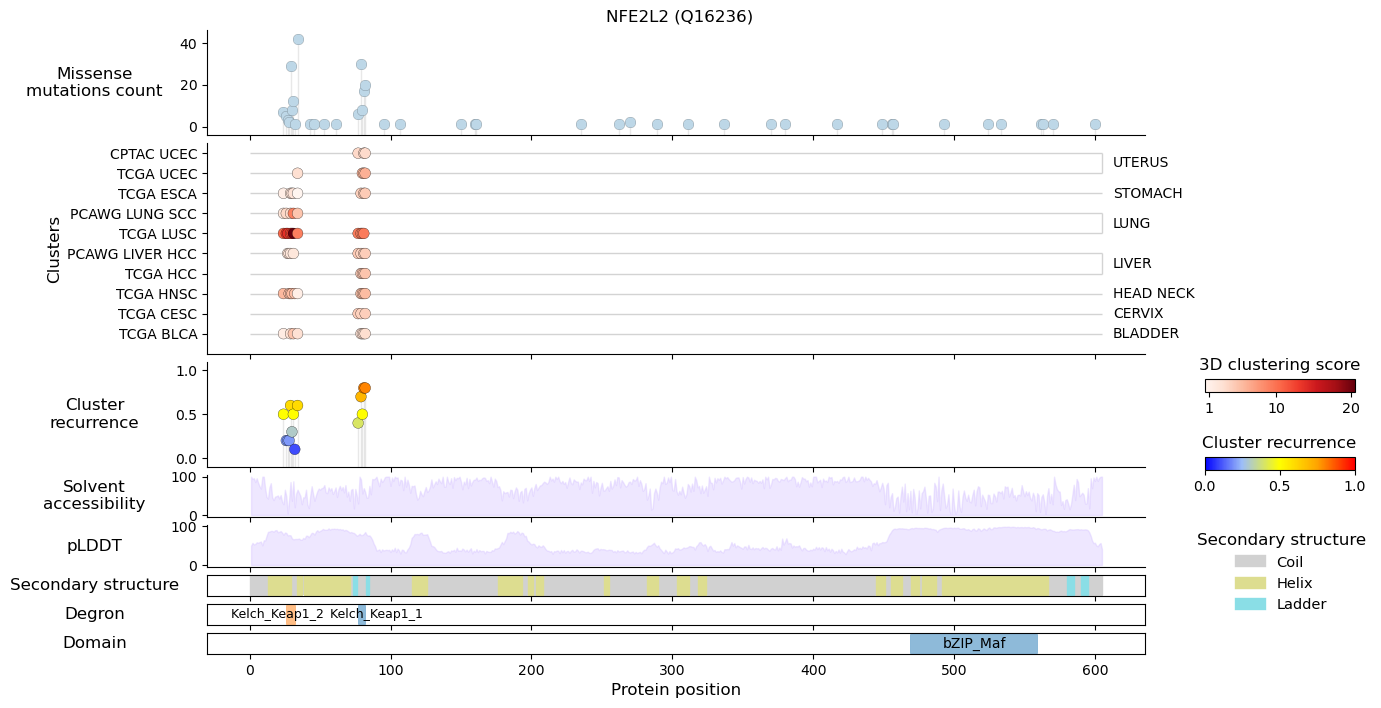

/tmp/ipykernel_2623022/3307234142.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cohort_df_gene["MAX_SCORE"] = [o3d_dict[gene][cohort]["Result"].Score_obs_sim.max() for cohort in cohort_df_gene.COHORT]
/tmp/ipykernel_2623022/3307234142.py:31: FutureWarning: The default value of regex will change from True to False in a future version.
  degmd_gene.DEGRON = degmd_gene.DEGRON.str.replace(" \(K\)", "")


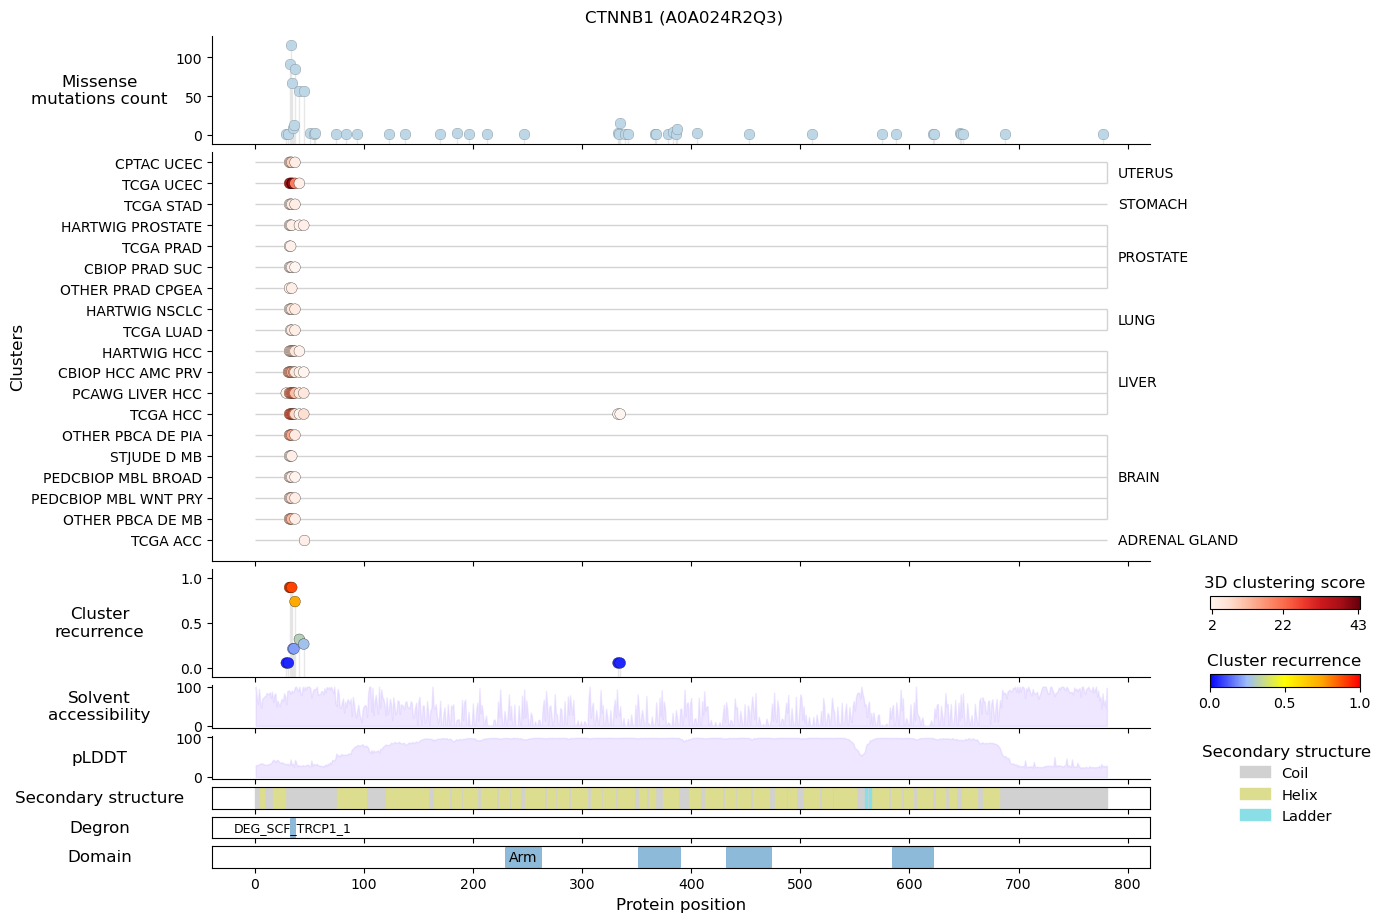

/tmp/ipykernel_2623022/3307234142.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cohort_df_gene["MAX_SCORE"] = [o3d_dict[gene][cohort]["Result"].Score_obs_sim.max() for cohort in cohort_df_gene.COHORT]
/tmp/ipykernel_2623022/3307234142.py:38: FutureWarning: The default value of regex will change from True to False in a future version.
  degmd_gene.DEGRON = degmd_gene.DEGRON.str.replace(" \(K\)", "")


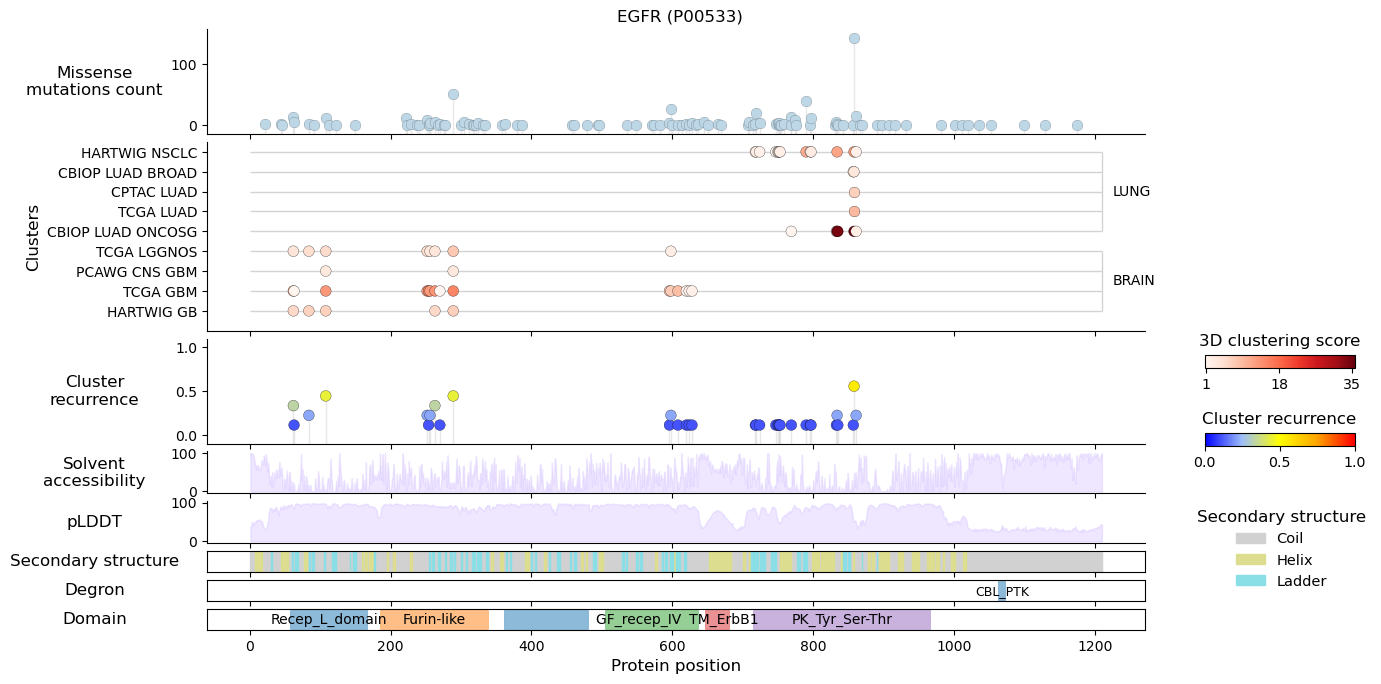

/tmp/ipykernel_2623022/3307234142.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cohort_df_gene["MAX_SCORE"] = [o3d_dict[gene][cohort]["Result"].Score_obs_sim.max() for cohort in cohort_df_gene.COHORT]
/tmp/ipykernel_2623022/3307234142.py:31: FutureWarning: The default value of regex will change from True to False in a future version.
  degmd_gene.DEGRON = degmd_gene.DEGRON.str.replace(" \(K\)", "")


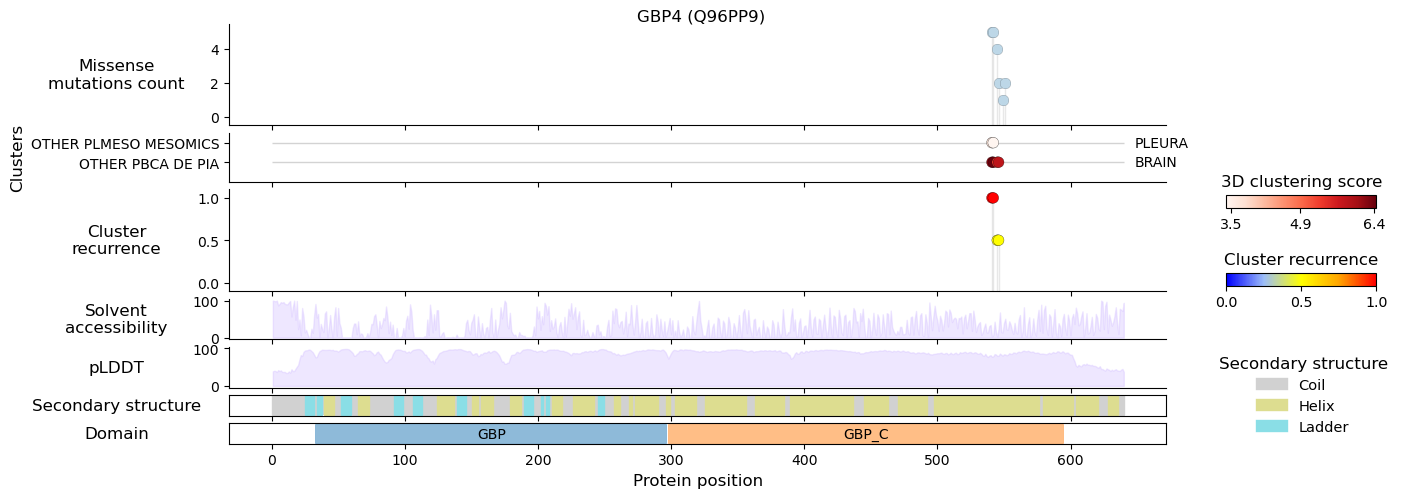

Gene, Uniprot ID tuple for cluster conservation: [('NFE2L2', 'Q16236'), ('CTNNB1', 'A0A024R2Q3'), ('EGFR', 'P00533'), ('GBP4', 'Q96PP9')]


In [14]:
genes_cluster_conservation = ["NFE2L2", "CTNNB1", "EGFR", "GBP4"]
uni_id_cluster_conservation = []
show_degron = True
annotated_deg = True
annotation_title = False

for i, gene in enumerate(["NFE2L2", "CTNNB1", "EGFR", "GBP4"]):

    uni_id, tr_id = o3d_seq_df.loc[o3d_seq_df["Gene"] == gene, ["Uniprot_ID", "Ens_Transcr_ID"]].values[0]
    pdb_tool_gene = o3d_pdb_tool_df[o3d_pdb_tool_df["Uniprot_ID"] == uni_id].reset_index(drop=True)
    domain_gene = o3d_annot_df[(o3d_annot_df["Gene"] == gene) & 
                               (o3d_annot_df["Type"] == "DOMAIN") & 
                               (o3d_annot_df["Evidence"] == "Pfam")].reset_index(drop=True)
    disorder_gene = disorder_df[disorder_df["Uniprot_ID"] == uni_id].reset_index(drop=True)
    if gene in ["EGFR", "ERBB2"]:
        domain_gene.Description = domain_gene.Description.replace("GF_recep_IV", "GF_recep_IV      ")
        domain_gene.Description = domain_gene.Description.replace("TM_ErbB1", "   TM_ErbB1")
    
    cohort_df_gene = cohort_df[cohort_df.COHORT.isin(o3d_dict[gene].keys())]
    cohort_df_gene["MAX_SCORE"] = [o3d_dict[gene][cohort]["Result"].Score_obs_sim.max() for cohort in cohort_df_gene.COHORT]
    cohort_df_gene = cohort_df_gene.sort_values(["GENERAL_CANCER_TYPE", "CANCER_TYPE", "MAX_SCORE"], ascending=[True, True, False]).reset_index(drop=True)

    if show_degron:
        degmd_gene = degmd_pred[degmd_pred["Entry"] == uni_id].reset_index(drop=True)
        if len(degmd_gene) == 0:
            uni_id_canonical, tr_id_canonical = o3d_seq_df_canonical.loc[o3d_seq_df_canonical["Gene"] == gene, ["Uniprot_ID", "Ens_Transcr_ID"]].values[0]
            if tr_id_canonical == tr_id:
                degmd_gene = degmd_pred[degmd_pred["Entry"] == uni_id_canonical].reset_index(drop=True)
                if annotated_deg:
                    degmd_gene = degmd_gene[degmd_gene.Annotated == "YES"]
                    degmd_gene.DEGRON = degmd_gene.DEGRON.str.replace(" \(K\)", "")
        else:
            if gene in ["NFE2L2"]:
                degmd_gene.DEGRON = degmd_gene.DEGRON.replace("DEG_Kelch_Keap1_1", "       Kelch_Keap1_1")
                degmd_gene.DEGRON = degmd_gene.DEGRON.replace("DEG_Kelch_Keap1_2", "Kelch_Keap1_2       ")
            if annotated_deg:
                degmd_gene = degmd_gene[degmd_gene.Annotated == "YES"]
                degmd_gene.DEGRON = degmd_gene.DEGRON.str.replace(" \(K\)", "")
    else:
        degmd_gene = pd.DataFrame(columns=['DEGRON'])

    if annotation_title:
        title = f'{gene} {is_gene_in_lst(gene, cgc_genes, "CGC"), is_gene_in_lst(gene, oncokb_genes, "OncoKB"), is_gene_in_lst(gene, intogen_genes, "IntOGen"), is_gene_in_lst(gene, hotmaps_genes, "HotMAPS")}'
    else:
        title = f"{gene} ({uni_id})" 
    missense_gene_df = missense_count_df[missense_count_df["Gene"] == gene]

    if gene in genes_cluster_conservation or gene in genes_order[genes_order > 4].index:
        filename = f"../../figures_and_tables/main/f6/f6.{gene}_recurrence.png"
    else:
        filename=None

    gene_conservation_df = plot_cluster_conservation(o3d_dict[gene],
                                                       missense_gene_df,
                                                       domain_gene, 
                                                       degmd_gene,
                                                       disorder_gene,
                                                       pdb_tool_gene,
                                                       cohort_df_gene,
                                                       gene,
                                                       plot_pars,
                                                       o3d_seq_df,
                                                       title=title,
                                                       absolute_score=True,
                                                       extend_clusters=True,
                                                       return_conservation_df=True,
                                                       filename=filename)

    if gene in genes_cluster_conservation:
        attr_file_path = f"data/cancer/{gene}.clusters_conservation.defattr"
        write_defattr_file(attr_file_path, gene, uni_id, gene_conservation_df)
        uni_id_cluster_conservation.append((gene, uni_id))

print("Gene, Uniprot ID tuple for cluster conservation:", uni_id_cluster_conservation)

## S10

/tmp/ipykernel_2623022/2289826843.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cohort_df_gene["MAX_SCORE"] = [o3d_dict[gene][cohort]["Result"].Score_obs_sim.max() for cohort in cohort_df_gene.COHORT]
/tmp/ipykernel_2623022/2289826843.py:33: FutureWarning: The default value of regex will change from True to False in a future version.
  degmd_gene.DEGRON = degmd_gene.DEGRON.str.replace(" \(K\)", "")


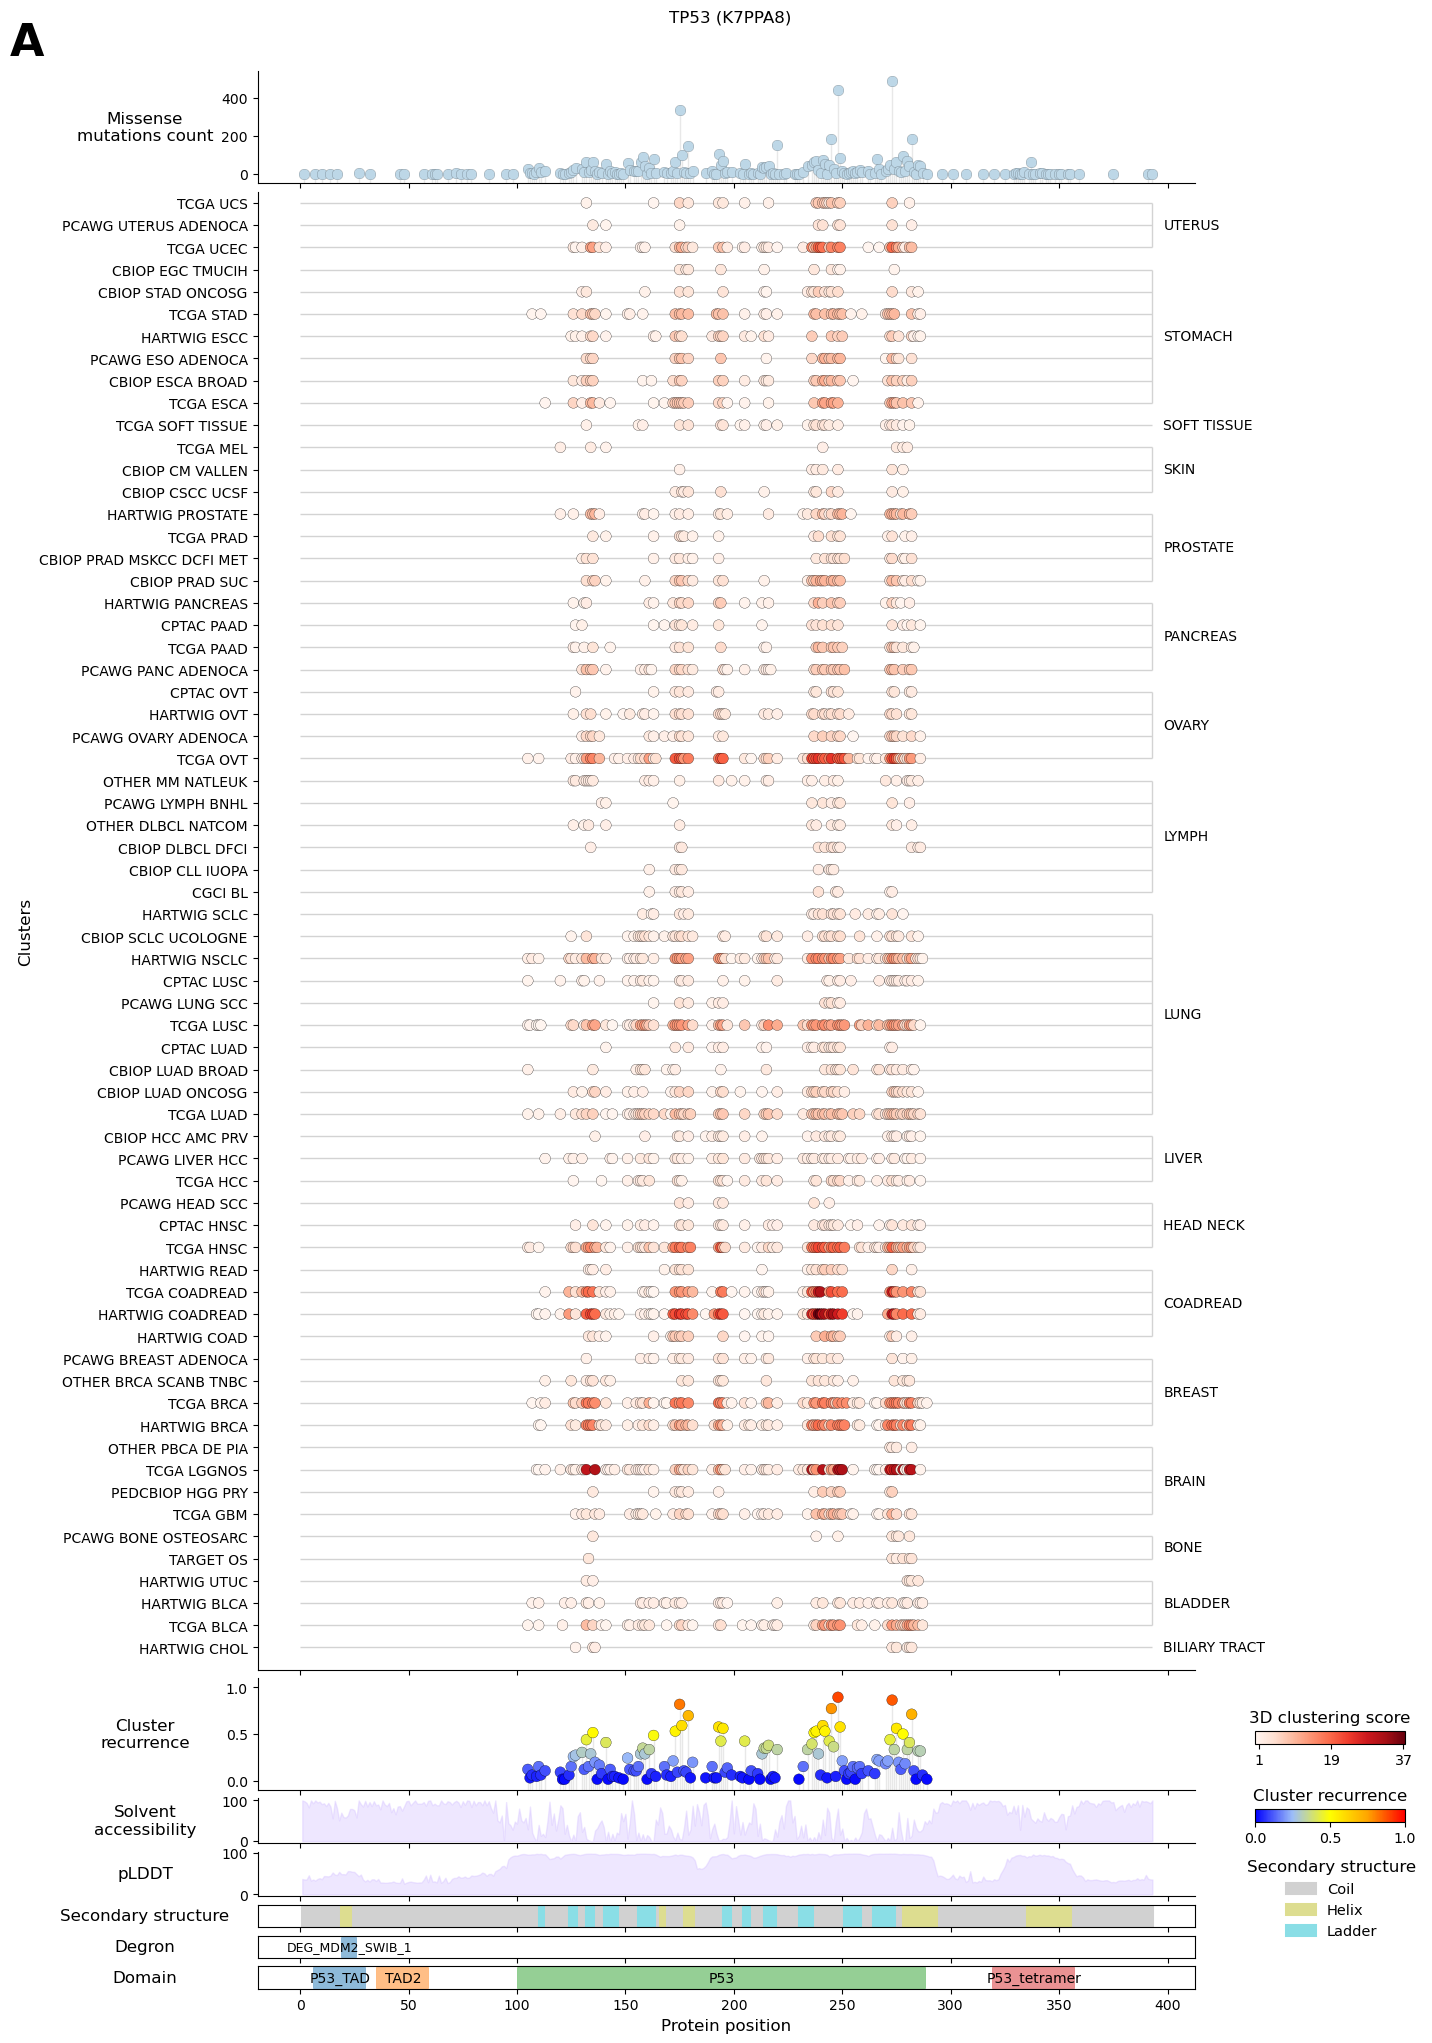

/tmp/ipykernel_2623022/2289826843.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cohort_df_gene["MAX_SCORE"] = [o3d_dict[gene][cohort]["Result"].Score_obs_sim.max() for cohort in cohort_df_gene.COHORT]
/tmp/ipykernel_2623022/2289826843.py:33: FutureWarning: The default value of regex will change from True to False in a future version.
  degmd_gene.DEGRON = degmd_gene.DEGRON.str.replace(" \(K\)", "")


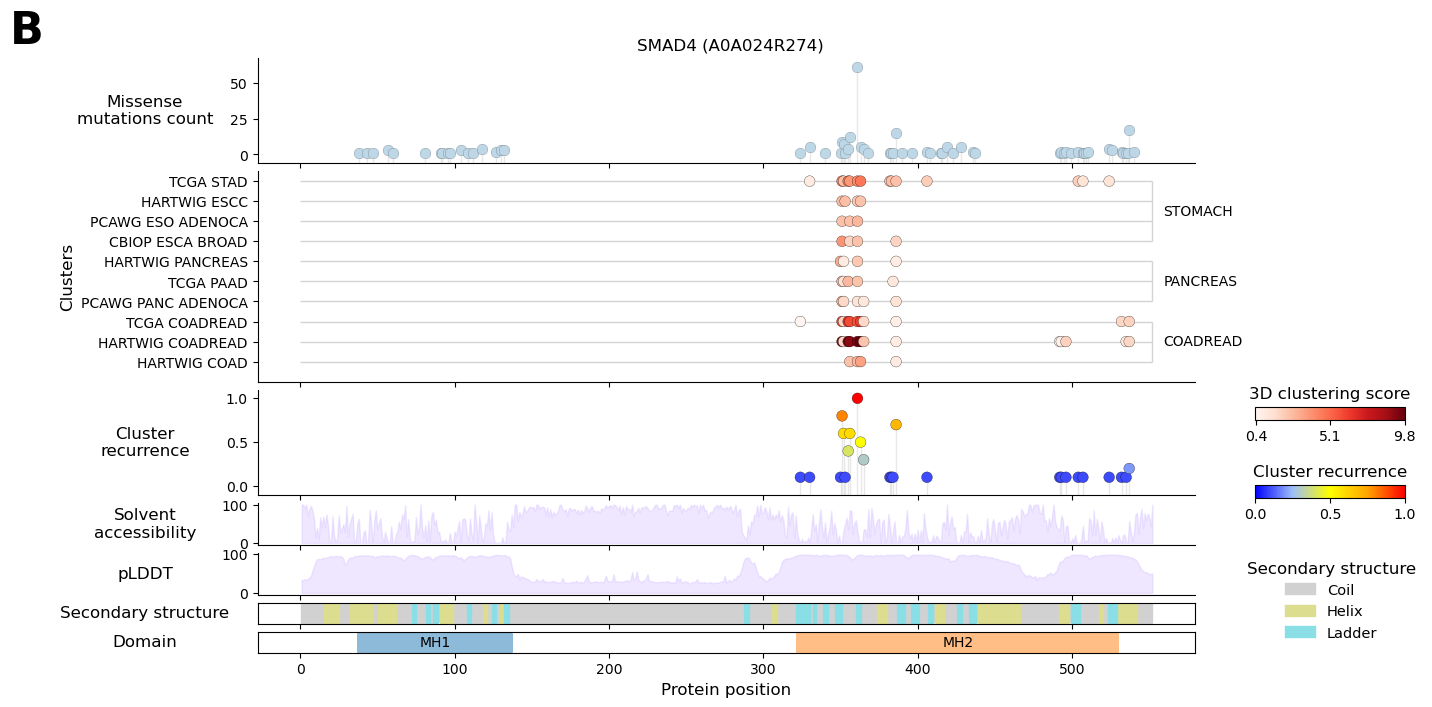

/tmp/ipykernel_2623022/2289826843.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cohort_df_gene["MAX_SCORE"] = [o3d_dict[gene][cohort]["Result"].Score_obs_sim.max() for cohort in cohort_df_gene.COHORT]
/tmp/ipykernel_2623022/2289826843.py:33: FutureWarning: The default value of regex will change from True to False in a future version.
  degmd_gene.DEGRON = degmd_gene.DEGRON.str.replace(" \(K\)", "")


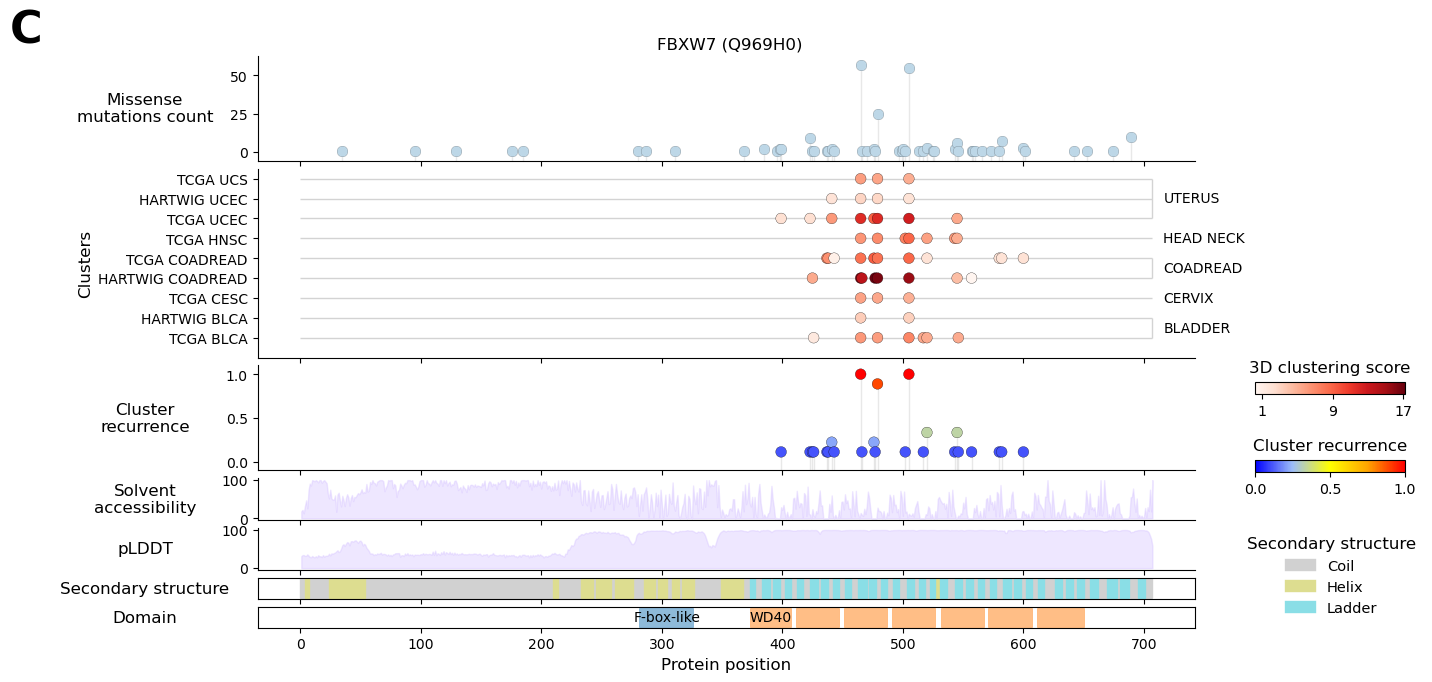

Gene, Uniprot ID tuple for cluster conservation: []


In [30]:
genes_cluster_conservation = []
uni_id_cluster_conservation = []
show_degron = True
annotated_deg = True
annotation_title = False
letters = ["A", "B", "C"]
letters_y = [0.9, 0.94, 0.94]

for i, gene in enumerate(["TP53", "SMAD4", "FBXW7"]):

    uni_id, tr_id = o3d_seq_df.loc[o3d_seq_df["Gene"] == gene, ["Uniprot_ID", "Ens_Transcr_ID"]].values[0]
    pdb_tool_gene = o3d_pdb_tool_df[o3d_pdb_tool_df["Uniprot_ID"] == uni_id].reset_index(drop=True)
    domain_gene = o3d_annot_df[(o3d_annot_df["Gene"] == gene) & 
                               (o3d_annot_df["Type"] == "DOMAIN") & 
                               (o3d_annot_df["Evidence"] == "Pfam")].reset_index(drop=True)
    disorder_gene = disorder_df[disorder_df["Uniprot_ID"] == uni_id].reset_index(drop=True)
    if gene in ["EGFR", "ERBB2"]:
        domain_gene.Description = domain_gene.Description.replace("GF_recep_IV", "GF_recep_IV      ")
        domain_gene.Description = domain_gene.Description.replace("TM_ErbB1", "   TM_ErbB1")
    
    cohort_df_gene = cohort_df[cohort_df.COHORT.isin(o3d_dict[gene].keys())]
    cohort_df_gene["MAX_SCORE"] = [o3d_dict[gene][cohort]["Result"].Score_obs_sim.max() for cohort in cohort_df_gene.COHORT]
    cohort_df_gene = cohort_df_gene.sort_values(["GENERAL_CANCER_TYPE", "CANCER_TYPE", "MAX_SCORE"], ascending=[True, True, False]).reset_index(drop=True)

    if show_degron:
        degmd_gene = degmd_pred[degmd_pred["Entry"] == uni_id].reset_index(drop=True)
        if len(degmd_gene) == 0:
            uni_id_canonical, tr_id_canonical = o3d_seq_df_canonical.loc[o3d_seq_df_canonical["Gene"] == gene, ["Uniprot_ID", "Ens_Transcr_ID"]].values[0]
            if tr_id_canonical == tr_id:
                degmd_gene = degmd_pred[degmd_pred["Entry"] == uni_id_canonical].reset_index(drop=True)
                if annotated_deg:
                    degmd_gene = degmd_gene[degmd_gene.Annotated == "YES"]
                    degmd_gene.DEGRON = degmd_gene.DEGRON.str.replace(" \(K\)", "")
        else:
            if gene in ["NFE2L2"]:
                degmd_gene.DEGRON = degmd_gene.DEGRON.replace("DEG_Kelch_Keap1_1", "       Kelch_Keap1_1")
                degmd_gene.DEGRON = degmd_gene.DEGRON.replace("DEG_Kelch_Keap1_2", "Kelch_Keap1_2       ")
            if annotated_deg:
                degmd_gene = degmd_gene[degmd_gene.Annotated == "YES"]
                degmd_gene.DEGRON = degmd_gene.DEGRON.str.replace(" \(K\)", "")
    else:
        degmd_gene = pd.DataFrame(columns=['DEGRON'])

    if annotation_title:
        title = f'{gene} {is_gene_in_lst(gene, cgc_genes, "CGC"), is_gene_in_lst(gene, oncokb_genes, "OncoKB"), is_gene_in_lst(gene, intogen_genes, "IntOGen"), is_gene_in_lst(gene, hotmaps_genes, "HotMAPS")}'
    else:
        title = f"{gene} ({uni_id})" 
    missense_gene_df = missense_count_df[missense_count_df["Gene"] == gene]

    if gene in genes_cluster_conservation or gene in genes_order[genes_order > 4].index:
        filename = f"../../figures_and_tables/supplementary/s10/s10.{gene}_recurrence.png"
    else:
        filename=None

    gene_conservation_df = plot_cluster_conservation(o3d_dict[gene],
                                                       missense_gene_df,
                                                       domain_gene, 
                                                       degmd_gene,
                                                       disorder_gene,
                                                       pdb_tool_gene,
                                                       cohort_df_gene,
                                                       gene,
                                                       plot_pars,
                                                       o3d_seq_df,
                                                       title=title,
                                                       absolute_score=True,
                                                       extend_clusters=True,
                                                       return_conservation_df=True,
                                                       filename=filename,
                                                       letter=letters[i],
                                                       letter_y=letters_y[i])

    if gene in genes_cluster_conservation:
        attr_file_path = f"data/cancer/{gene}.clusters_conservation.defattr"
        write_defattr_file(attr_file_path, gene, uni_id, gene_conservation_df)
        uni_id_cluster_conservation.append((gene, uni_id))

print("Gene, Uniprot ID tuple for cluster conservation:", uni_id_cluster_conservation)

# S12: Cluster recurrence in CH and AML

In [30]:
def plot_cluster_conservation_ch(o3d_dict,
                               mut_df,
                               mut_ch_df,
                               domain_df,
                               degron_df,
                               disorder_df,
                               pdb_tool_df,
                               cohort_df,
                               gene,
                               plot_pars,
                               o3d_seq_df,
                               title=None,
                               alpha_scatter=1,
                               figsize=(15,9),
                               j_margin=15,
                               hratio_one_cohort=0.05,
                               hratio_needle=0.25,
                               needle_ypad_ratio=0.1,
                               hspace_proportion=0.3,
                               len_txt_thr=2400,
                               len_txt_thr_degron=600,
                               absolute_score=False,
                               extend_clusters=True,
                               filename=None,
                               return_conservation_df=False,
                               predicted_degrons=False):
    
    # Set height of tracks
    cohort_df_ch = cohort_df_gene[cohort_df_gene["GENERAL_CANCER_TYPE"] == "CH"].reset_index(drop=True)
    cohort_df_cancer = cohort_df_gene[cohort_df_gene["GENERAL_CANCER_TYPE"] != "CH"].reset_index(drop=True)
    n_ch_cohorts = len(cohort_df_ch)
    n_cancer_cohort = len(cohort_df_cancer)
    n_cohorts = len(o3d_dict.keys())
    hratio_one_cohort_ch = 0.06 if n_ch_cohorts < 5 else hratio_one_cohort
    hratio_one_cohort_cancer = 0.06 if n_cancer_cohort < 5 else hratio_one_cohort
    dynamic_height_ch = hratio_one_cohort * n_ch_cohorts  
    dynamic_height_cancer = hratio_one_cohort * n_cancer_cohort  
    
    if n_ch_cohorts == 1:
        if n_cancer_cohort > 0:
            h_ratios = [hratio_needle, 
                        dynamic_height_ch, 
                        hratio_needle, 
                        dynamic_height_cancer,
                        0.1, 
                        0.05, 
                        0.05, 
                        0.05,
                        0.05]
        else:
            h_ratios = [hratio_needle, 
                        dynamic_height_ch, 
                        0.1, 
                        0.05, 
                        0.05, 
                        0.05,
                        0.05]  
    else:
        h_ratios = [hratio_needle, 
                    dynamic_height_ch, 
                    hratio_needle*0.75, 
                    hratio_needle, 
                    dynamic_height_cancer,
                    0.1,
                    0.05, 
                    0.05, 
                    0.05,
                    0.05]

    if len(mut_df) > 0:
        tm_mut_ax = 2
    else:
        tm_mut_ax = 0
    base_height_per_unit = 7 
    total_height = sum(h_ratios) * base_height_per_unit
    hspace = hspace_proportion * base_height_per_unit / total_height
    
    fig, axes = plt.subplots(len(h_ratios), 1, 
                             figsize=(figsize[0], total_height),
                             sharex=True, 
                             gridspec_kw={'hspace': hspace, 
                                          'height_ratios': h_ratios})
    
 
    # Missense mutations CH
    # =====================

    max_count_ch = np.max(mut_ch_df["Count"])
    ax_ylim_min_ch = 0-max_count_ch*needle_ypad_ratio
    ax_ylim_max_ch = max_count_ch+max_count_ch*needle_ypad_ratio

    axes[0].vlines(mut_ch_df["Pos"], ymin=ax_ylim_min_ch, ymax=mut_ch_df["Count"], lw=1, zorder=1, alpha=0.5, color="lightgray")
    axes[0].scatter(mut_ch_df["Pos"], mut_ch_df["Count"], color='white', zorder=3, lw=1, ec="white") # To cover the overlapping needle top part
    axes[0].scatter(mut_ch_df["Pos"], mut_ch_df["Count"].values, zorder=4, 
                     alpha=alpha_scatter, lw=0.1, ec="black", s=60, color="#c4edd8")  
    
    axes[0].set_ylim(ax_ylim_min_ch, ax_ylim_max_ch)
    axes[0].set_ylabel(f'CH\nmissense\nmutations count', fontsize=plot_pars["ylabel_fontsize"], rotation=0, va='center')
    axes[0].yaxis.set_label_coords(plot_pars["y_labels_coord"][0], plot_pars["y_labels_coord"][1])


    # Clusters CH
    # ===========

    if extend_clusters:
        score_max = np.max([o3d_dict[cohort]["Result"][o3d_dict[cohort]["Result"].C == 1].Score_obs_sim.max() for cohort in o3d_dict.keys()])
        score_min = np.min([o3d_dict[cohort]["Result"][o3d_dict[cohort]["Result"].C == 1].Score_obs_sim.min() for cohort in o3d_dict.keys()])
    else:
        score_max = np.max([o3d_dict[cohort]["Result"][(o3d_dict[cohort]["Result"].C == 1) & (o3d_dict[cohort]["Result"].C_ext == 0)].Score_obs_sim.max() for cohort in o3d_dict.keys()])
        score_min = np.min([o3d_dict[cohort]["Result"][(o3d_dict[cohort]["Result"].C == 1) & (o3d_dict[cohort]["Result"].C_ext == 0)].Score_obs_sim.min() for cohort in o3d_dict.keys()])
    
    for i, cohort in enumerate(cohort_df_ch.COHORT.values):

        o3d_cohort_df_ch = get_o3d_gene_data(gene, o3d_seq_df, o3d_dict[cohort]["Result"], extend_clusters=extend_clusters)
        gene_len = len(disorder_df)

        axes[1].hlines(y=i, xmin=0, xmax=gene_len, linewidth=1, color='lightgray', alpha=1, zorder=0)
        cluster_pos = o3d_cohort_df_ch[o3d_cohort_df_ch["Cluster"] == 1].Pos.values
        cluster_score = o3d_cohort_df_ch[o3d_cohort_df_ch["Cluster"] == 1].O3D_score.values 

        scatter = axes[1].scatter(y=np.repeat(i, len(cluster_pos)), x=cluster_pos, 
                                c=cluster_score, cmap='Reds', 
                                vmin=score_min if absolute_score else None, 
                                vmax=score_max if absolute_score else None, 
                                zorder=2, lw=0.2, label=cohort, alpha=alpha_scatter, ec="black", s=60) 
    axes[1].set_yticks([])
    axes[1].set_ylim(-1, n_ch_cohorts-0.5)
    axes[1].set_ylabel(f'CH clusters', fontsize=plot_pars["ylabel_fontsize"], rotation=0, va='center')
    axes[1].yaxis.set_label_coords(plot_pars["y_labels_coord"][0], plot_pars["y_labels_coord"][1])

    # Cbar
    # ----
    
    fig_width, fig_height = fig.get_size_inches()
    margin_factor = 0.2 
    colorbar_y_position = margin_factor + (0.32 * (6 / fig_height)) 
    colorbar_height = 0.015 * (8.5 / fig_height)  
    fig.subplots_adjust(right=0.75)
    cbar_ax = fig.add_axes([0.79, colorbar_y_position, 0.1, colorbar_height])
    cbar = fig.colorbar(scatter, cax=cbar_ax, orientation='horizontal')
    cbar.set_label('3D clustering score' if absolute_score else 'Relative 3D\nclustering score', 
                   fontsize=plot_pars["legend_fontsize"], labelpad=6.5)
    cbar.ax.xaxis.set_label_position('top')
    
    cbar.ax.tick_params(labelsize=plot_pars["ticksize"])    
    if not absolute_score:
        span = cluster_score.max() - cluster_score.min()
        left_tick = cluster_score.min() + 0.1 * span  
        right_tick = cluster_score.max() - 0.1 * span 
        tick_values = [left_tick, right_tick]
        cbar.set_ticks(tick_values)
        cbar.set_ticklabels([tick for tick in ["Low", "High"]])
    else:
        span = score_max - score_min
        j = 1 if span > 10 else 10 if span > 1 else 100
        ticks = np.linspace(score_min, score_max, 3)
        cbar.set_ticks([np.ceil(ticks[0] * j) / j, np.round(ticks[1] * j) / j, np.floor(ticks[2] * j) / j])
    

    # Tissue annotation
    # -----------------

    for y, cohort in enumerate(cohort_df_ch.COHORT):
        axes[1].text(x=gene_len + gene_len*0.013, y=y, s=clean_cohort_name(cohort), 
                     verticalalignment='center', fontsize=10, color="black")


    # Conservation of clusters
    # ========================
    
    if n_ch_cohorts > 1:
        colors = ["blue", "#9DBEF8", "yellow", "orange", "red"]
        custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)
        
        df_gene = pd.concat([o3d_dict[cohort]["Result"] for cohort in o3d_dict.keys()])
        df_gene = df_gene[df_gene.Cohort.isin(cohort_df_ch.COHORT.values)].reset_index(drop=True)
        if extend_clusters:
            conservation_df = df_gene[df_gene["C"] == 1].value_counts("Pos") / n_ch_cohorts
        else:
            conservation_df = df_gene[(df_gene["C"] == 1) & (df_gene["C_ext"] == 0)].value_counts("Pos") / n_ch_cohorts
        conservation_df = conservation_df.reset_index().rename(columns = {0 : "Conservation"}).sort_values("Pos").reset_index(drop=True)
        
        axes[2].vlines(conservation_df["Pos"], ymin=-0.1, ymax=conservation_df["Conservation"], lw=1, zorder=1, alpha=0.5, color="lightgray")
        scatter = axes[2].scatter(y=conservation_df["Conservation"], 
                                            x=conservation_df["Pos"], 
                                            c=conservation_df["Conservation"], 
                                            cmap=custom_cmap, vmin=0, vmax=1,
                                            zorder=2, lw=0.2, alpha=alpha_scatter, ec="black", s=60)
        ax_ylim_min, ax_ylim_max = 0-1*needle_ypad_ratio, 1+1*needle_ypad_ratio
        axes[2].set_ylim(ax_ylim_min, ax_ylim_max)
        axes[2].set_ylabel('CH cluster\nrecurrence', fontsize=plot_pars["ylabel_fontsize"], rotation=0, va='center')
        axes[2].yaxis.set_label_coords(plot_pars["y_labels_coord"][0], plot_pars["y_labels_coord"][1]) 
        axes[2].set_yticks([0, 0.5, 1])
    
        # Cbar
        fig_width, fig_height = fig.get_size_inches()
        margin_factor = 0.2 
        colorbar_y_position = margin_factor + (0.45 * (6 / fig_height)) 
        colorbar_height = 0.015 * (8.5 / fig_height)  
        fig.subplots_adjust(right=0.75)
        cbar_ax = fig.add_axes([0.79, colorbar_y_position, 0.1, colorbar_height])
        cbar = fig.colorbar(scatter, cax=cbar_ax, orientation='horizontal')
        cbar.set_label('CH cluster recurrence', fontsize=plot_pars["legend_fontsize"], labelpad=6.5)
        cbar.ax.xaxis.set_label_position('top')
        cbar.ax.tick_params(labelsize=plot_pars["ticksize"])    
    else:
        tm_mut_ax -= 1

        
    # Missense mutations cancer
    # =========================

    ax=1+tm_mut_ax    
    if len(mut_df) > 0:
        max_count = np.max(mut_df["Count"])
        ax_ylim_min = 0-max_count*needle_ypad_ratio
        ax_ylim_max = max_count+max_count*needle_ypad_ratio

        label = "AML" if "AML" in cohort_df.GENERAL_CANCER_TYPE.values else "Tumor"
        axes[ax].set_ylabel(f'{label}\nmissense\nmutations count', fontsize=plot_pars["ylabel_fontsize"], rotation=0, va='center')
        axes[ax].yaxis.set_label_coords(plot_pars["y_labels_coord"][0]-0.002, plot_pars["y_labels_coord"][1])
        axes[ax].vlines(mut_df["Pos"], ymin=ax_ylim_min, ymax=mut_df["Count"], lw=1, zorder=1, alpha=0.5, color="lightgray")
        axes[ax].scatter(mut_df["Pos"], mut_df["Count"], color='white', zorder=3, lw=1, ec="white") # To cover the overlapping needle top part
        axes[ax].scatter(mut_df["Pos"], mut_df["Count"].values, zorder=4, 
                        alpha=alpha_scatter, lw=0.1, ec="black", s=60, color="#BDD7E7") 
        axes[ax].set_ylim(ax_ylim_min, ax_ylim_max)

    
    # Clusters Cancer
    # ===============

    ax = 2+tm_mut_ax    
    if len(mut_df) > 0:
        if extend_clusters:
            score_max = np.max([o3d_dict[cohort]["Result"][o3d_dict[cohort]["Result"].C == 1].Score_obs_sim.max() for cohort in o3d_dict.keys()])
            score_min = np.min([o3d_dict[cohort]["Result"][o3d_dict[cohort]["Result"].C == 1].Score_obs_sim.min() for cohort in o3d_dict.keys()])
        else:
            score_max = np.max([o3d_dict[cohort]["Result"][(o3d_dict[cohort]["Result"].C == 1) & (o3d_dict[cohort]["Result"].C_ext == 0)].Score_obs_sim.max() for cohort in o3d_dict.keys()])
            score_min = np.min([o3d_dict[cohort]["Result"][(o3d_dict[cohort]["Result"].C == 1) & (o3d_dict[cohort]["Result"].C_ext == 0)].Score_obs_sim.min() for cohort in o3d_dict.keys()])
    
        for i, cohort in enumerate(cohort_df_cancer.COHORT.values):
    
            o3d_cohort_df_cancer = get_o3d_gene_data(gene, o3d_seq_df, o3d_dict[cohort]["Result"], extend_clusters=extend_clusters)
            gene_len = len(disorder_df)
    
            axes[ax].hlines(y=i, xmin=0, xmax=gene_len, linewidth=1, color='lightgray', alpha=1, zorder=0)
            cluster_pos = o3d_cohort_df_cancer[o3d_cohort_df_cancer["Cluster"] == 1].Pos.values
            cluster_score = o3d_cohort_df_cancer[o3d_cohort_df_cancer["Cluster"] == 1].O3D_score.values 
    
            scatter = axes[ax].scatter(y=np.repeat(i, len(cluster_pos)), x=cluster_pos, 
                                    c=cluster_score, cmap='Reds', 
                                    vmin=score_min if absolute_score else None, 
                                    vmax=score_max if absolute_score else None, 
                                    zorder=2, lw=0.2, label=cohort, alpha=alpha_scatter, ec="black", s=60) 
    
        axes[ax].set_ylim(-1, n_cancer_cohort-0.5)

        
        # Tissue annotation
        # -----------------

        if "AML" in cohort_df_cancer.GENERAL_CANCER_TYPE.unique():
            for y, cohort in enumerate(cohort_df_cancer.COHORT):
                axes[ax].text(x=gene_len + gene_len*0.013, y=y, s=clean_cohort_name(cohort), 
                             verticalalignment='center', fontsize=10, color="black")
            axes[ax].set_yticks([])
            axes[ax].set_ylabel(f'AML clusters', fontsize=plot_pars["ylabel_fontsize"], rotation=0, va='center')
            axes[ax].yaxis.set_label_coords(plot_pars["y_labels_coord"][0], plot_pars["y_labels_coord"][1])
        else:
                
            for indices, tissue_name in cohort_df_cancer.groupby("GENERAL_CANCER_TYPE").apply(lambda x: (x.index, x.name)):
                y_start = indices[0]
                y_end = indices[-1]
                y_pos = (y_start + y_end) / 2
                axes[ax].vlines(x=gene_len, ymin=y_start, ymax=y_end, color="lightgray", lw=1, zorder=0)
                axes[ax].text(x=gene_len + gene_len*0.013, y=y_pos, s=tissue_name.replace("_", " "), 
                             verticalalignment='center', fontsize=10, color="black")
            y_ticks_positions = np.arange(n_cancer_cohort)   
            axes[ax].set_yticks(y_ticks_positions)
            axes[ax].set_yticklabels([clean_cohort_name(cohort) for cohort in cohort_df_cancer.COHORT.values])
            axes[ax].set_ylabel('Cancer\nclusters\n', fontsize=plot_pars["ylabel_fontsize"])
    
        
    # Track pACC
    # ==========

    ax=3+tm_mut_ax

    if isinstance(pdb_tool_df, pd.DataFrame):
        max_pacc = np.max(pdb_tool_df["pACC"].fillna(0))
        axes[ax].fill_between(pdb_tool_df["Pos"], 0, pdb_tool_df["pACC"].fillna(0),                  
                              zorder=2, color=sns.color_palette("pastel")[4], alpha=0.35)
        axes[ax].set_ylabel('Solvent\naccessibility', fontsize=plot_pars["ylabel_fontsize"], rotation=0, va='center')
        axes[ax].yaxis.set_label_coords(plot_pars["y_labels_coord"][0], plot_pars["y_labels_coord"][1])
    else:
        axes[ax].remove()


    # pLDDT
    # ==========

    ax=4+tm_mut_ax

    if isinstance(disorder_df, pd.DataFrame):
        max_pacc = np.max(disorder_df["Confidence"].fillna(0))
        axes[ax].fill_between(disorder_df["Pos"], 0, disorder_df["Confidence"].fillna(0),                  
                              zorder=2, color=sns.color_palette("pastel")[4], alpha=0.35)
        axes[ax].set_ylabel('pLDDT', fontsize=plot_pars["ylabel_fontsize"], rotation=0, va='center')
        axes[ax].yaxis.set_label_coords(plot_pars["y_labels_coord"][0], plot_pars["y_labels_coord"][1])
    else:
        axes[ax].remove()


    # Track SSE
    # =========

    ax=5+tm_mut_ax
   
    if isinstance(pdb_tool_df, pd.DataFrame):
        for n, sse in enumerate(('Coil', 'Helix', 'Ladder')):   
            axes[ax].fill_between(pdb_tool_df["Pos"], 0, 1, where=(pdb_tool_df['SSE'] == sse),
                                  zorder=2, color=plot_pars["sse_colors"][sse], 
                                  alpha=1, 
                                  label=sse, 
                                  lw=4.2 if gene_len < 200 else 3.4 if gene_len < 300 else 2.2 if gene_len < 450 else 1.7 if gene_len < 1000 else 1)
        axes[ax].set_yticks([])  
        axes[ax].legend(fontsize=10.5, frameon=plot_pars["legend_frameon"], 
                        bbox_to_anchor=plot_pars["sse_bbox_to_anchor"], title = "Secondary structure", 
                        title_fontsize=plot_pars["legend_fontsize"], 
                        handleheight=0.67, handlelength=2, markerscale=1) 
        axes[ax].set_ylabel('Secondary structure', fontsize=plot_pars["ylabel_fontsize"], rotation=0, va='center')
        axes[ax].yaxis.set_label_coords(plot_pars["y_labels_coord"][0], plot_pars["y_labels_coord"][1])
    else:
        axes[ax].remove()


    # Track degron
    # ============

    ax=6+tm_mut_ax

    if len(degron_df["DEGRON"]) > 0:
        if predicted_degrons:
            degron_df["DEGRON"] = degron_df.apply(lambda x: f"{x.DEGRON} ({'K' if x.Annotated == 'YES' else 'P'})", axis=1)
        degron_color_dict = {}
        genes_clashing_degrons = ["FOXA1", "PTEN", "KLF5"]
        genes_not_clashing_degrons = ["AR", "FGFR3", "BRAF", "SMO", "KIT", "EGFR", "NFE2L2"]
        for n, name in enumerate(degron_df["DEGRON"].unique()):
            degron_color_dict[name] = f"C{n}"
            
        n = 0
        added_degron = []
        for i, row in degron_df.iterrows():
            if pd.Series([row["DEGRON"], row["Begin"], row["End"]]).isnull().any():
                continue
    
            name = row["DEGRON"]
            start = int(row["Begin"])
            end = int(row["End"])
            
            if name not in added_degron and (gene_len >= len_txt_thr_degron or gene in genes_clashing_degrons) and gene not in genes_not_clashing_degrons and len(degron_df["DEGRON"].unique()) > 1:
                axes[ax].fill_between(range(start, end + 1), -0.5, 0.45, alpha=0.5, color=degron_color_dict[name], label=name, lw=0.5)
            else:
                axes[ax].fill_between(range(start, end + 1), -0.5, 0.45, alpha=0.5, color=degron_color_dict[name], lw=0.5)
            
            if name not in added_degron:
                if ((gene_len < len_txt_thr_degron and gene not in genes_clashing_degrons) or gene in genes_not_clashing_degrons or len(degron_df["DEGRON"].unique()) == 1):
                    y = -0.04
                    axes[ax].text(((start + end) / 2)+0.5, y, name, ha='center', va='center', fontsize=9, color="black")
                added_degron.append(name)
        axes[ax].set_yticks([])  
        if ((gene_len >= len_txt_thr_degron or gene in genes_clashing_degrons) and len(added_degron) > 0) and gene not in genes_not_clashing_degrons and len(degron_df["DEGRON"].unique()) > 1:
            axes[ax].legend(fontsize=10.5, frameon=plot_pars["legend_frameon"], loc="upper center",
                            bbox_to_anchor=(1.155, -0.2),
                            title = "Degron", 
                            title_fontsize=plot_pars["legend_fontsize"],
                            handleheight=0.67, handlelength=2) 
        axes[ax].set_ylabel('Degron', fontsize=plot_pars["ylabel_fontsize"], rotation=0, va='center')
        axes[ax].yaxis.set_label_coords(plot_pars["y_labels_coord"][0], plot_pars["y_labels_coord"][1])
        ix = 0
    else:
        ix = 1
    
        
    # Track Domain
    # ============

    ax=7-ix+tm_mut_ax

    if isinstance(domain_df, pd.DataFrame):
        domain_color_dict = {}
        genes_clashing_domains = ["KDM6A", "XPO1"]

        for n, name in enumerate(domain_df["Description"].unique()):
            domain_color_dict[name] = f"C{n}"

        n = 0
        added_domain = []
        for i, row in domain_df.iterrows():
            if pd.Series([row["Description"], row["Begin"], row["End"]]).isnull().any():
                continue

            name = row["Description"]
            start = int(row["Begin"])
            end = int(row["End"])
            
            if name not in added_domain and (gene_len >= len_txt_thr or gene in genes_clashing_domains):
                axes[ax].fill_between(range(start, end + 1), -0.5, 0.45, alpha=0.5, color=domain_color_dict[name], label=name, lw=0.5)
            else:
                axes[ax].fill_between(range(start, end + 1), -0.5, 0.45, alpha=0.5, color=domain_color_dict[name], lw=0.5)
            
            if name not in added_domain:
                if gene_len < len_txt_thr and gene not in genes_clashing_domains:
                    y = -0.04
                    axes[ax].text(((start + end) / 2)+0.5, y, name, ha='center', va='center', fontsize=10, color="black")
                added_domain.append(name)
        axes[ax].set_yticks([])  
        if (gene_len >= len_txt_thr or gene in genes_clashing_domains) and len(added_domain) > 0:
            axes[ax].legend(fontsize=10.5, frameon=plot_pars["legend_frameon"], loc="lower center",
                            bbox_to_anchor=plot_pars["domain_bbox_to_anchor"], title = "Domain", 
                            title_fontsize=plot_pars["legend_fontsize"],
                            handleheight=0.67, handlelength=2) 
        axes[ax].set_ylabel('Domain', fontsize=plot_pars["ylabel_fontsize"], rotation=0, va='center')
        axes[ax].yaxis.set_label_coords(plot_pars["y_labels_coord"][0], plot_pars["y_labels_coord"][1])
    else:
        axes[ax].remove()

    if ix == 1:
        axes[ax+ix].remove()
        axes[-2].tick_params(labelbottom=True)
        axes[-2].set_xlabel("Protein position", fontsize=plot_pars["ylabel_fontsize"])
    else:
        axes[-1].set_xlabel("Protein position", fontsize=plot_pars["ylabel_fontsize"])

    
    # Details
    # =======

    if gene is not None:
        fig.suptitle(title, y=0.905, x=0.44)

    for n in range(5+tm_mut_ax):
        axes[n].spines['top'].set_visible(False)
        axes[n].spines['right'].set_visible(False)
    
    if filename:
        plt.savefig(filename, dpi=900, bbox_inches='tight')
    plt.show()

    if n_ch_cohorts > 1:
        if return_conservation_df and n_cohorts > 1:
            return conservation_df

## Missense mut

In [31]:
# Get all myeloid cohorts and CH
o3d_ch_output_dir = f"{datasets}/ch/o3d_output/{SUBDIR_CH}/{RUN_CH}"
cohorts = ["OTHER_WGS_HMF_FULL", "OTHER_WXS_CH_IMPACT_PANEL", "OTHER_WXS_TCGA_FULL"]

cohort_ch_df = pd.DataFrame({"COHORT" : cohorts,
                              "CANCER_TYPE" : np.nan,
                              "PLATFORM" : np.nan,
                              "MUTATIONS" : np.nan, 
                              "SAMPLES" : np.nan,
                              "GENERAL_CANCER_TYPE" : "CH"})

cohort_all_df = pd.concat((cohort_df, cohort_ch_df)).reset_index(drop=True)
cohort_all_ch_df = pd.concat((cohort_df[cohort_df["CANCER_TYPE"] == "AML"], cohort_ch_df)).reset_index(drop=True)
cohort_all_ch_df.GENERAL_CANCER_TYPE = cohort_all_ch_df.GENERAL_CANCER_TYPE.replace("MYELOID", "AML")
cohort_all_ch_df

,COHORT,CANCER_TYPE,PLATFORM,MUTATIONS,SAMPLES,GENERAL_CANCER_TYPE
0,STJUDE_WGS_D_AML_2018,AML,WGS,30265.0,21.0,AML
1,PCAWG_WGS_MYELOID_AML,AML,WGS,20309.0,13.0,AML
2,OTHER_WXS_AML_PRY_BEAT_2018,AML,WXS,79225.0,257.0,AML
3,PEDCBIOP_WXS_AML_PRY,AML,WXS,233.0,28.0,AML
4,TARGET_WXS_AML_2020,AML,WXS,962.0,22.0,AML
5,TCGA_WXS_AML,AML,WXS,8313.0,140.0,AML
6,OTHER_WGS_HMF_FULL,NaN,NaN,NaN,NaN,CH
7,OTHER_WXS_CH_IMPACT_PANEL,NaN,NaN,NaN,NaN,CH
8,OTHER_WXS_TCGA_FULL,NaN,NaN,NaN,NaN,CH


In [32]:
## Get o3d pos result for ch

o3d_ch_pos_result = get_o3d_result(cohorts, o3d_ch_output_dir)
o3d_ch_pos_result

,Gene,Uniprot_ID,F,Pos,Mut_in_gene,Score_obs_sim,C,C_ext,Cancer,Cohort
75,AHNAK,Q09666,24M,3471,21,3.953334,1,0.0,NaN,OTHER_WGS_HMF_FULL
76,AHNAK,Q09666,24M,1671,21,3.329254,1,0.0,NaN,OTHER_WGS_HMF_FULL
77,AHNAK,Q09666,24M,5717,21,0.450493,0,NaN,NaN,OTHER_WGS_HMF_FULL
78,AHNAK,Q09666,24M,2335,21,0.436987,0,NaN,NaN,OTHER_WGS_HMF_FULL
79,AHNAK,Q09666,24M,4969,21,0.431308,0,NaN,NaN,OTHER_WGS_HMF_FULL
...,...,...,...,...,...,...,...,...,...,...
176410,ZNF106,Q9H2Y7,1,1626,63,0.309666,0,NaN,NaN,OTHER_WXS_TCGA_FULL
176411,ZNF106,Q9H2Y7,1,1101,63,0.312538,0,NaN,NaN,OTHER_WXS_TCGA_FULL
176412,ZNF106,Q9H2Y7,1,1807,63,0.298748,0,NaN,NaN,OTHER_WXS_TCGA_FULL
176413,ZNF106,Q9H2Y7,1,1868,63,0.285253,0,NaN,NaN,OTHER_WXS_TCGA_FULL


In [33]:
# Get o3d ch dict

o3d_ch_dict = {}
for gene in o3d_ch_pos_result.Gene.unique(): 
    print(gene)
    o3d_ch_dict[gene] = {}
    for cohort in o3d_ch_pos_result[o3d_ch_pos_result["Gene"] == gene].Cohort.unique():
        o3d_gene_cohort_ch = o3d_ch_pos_result.loc[(o3d_ch_pos_result["Gene"] == gene) & (o3d_ch_pos_result["Cohort"] == cohort)]
        o3d_ch_dict[gene][cohort] = {}
        o3d_ch_dict[gene][cohort]["Result"] = o3d_gene_cohort_ch

AHNAK
ARMCX4
BICRA
C11orf95
COL8A1
COL8A2
DHX58
DNMT3A
FLYWCH1
FNBP1L
FOXN4
JAK2
KCNA7
KIAA1210
KNL1
LOR
MARCKS
NLRP13
NR0B1
OR4C5
PIWIL3
PLEC
RAB44
RASAL3
RBM15B
RTL9
SCART1
SECISBP2
SHANK1
SOX4
SPATA31E1
TCHH
ZMAT1
ZNF224
ZNF264
ZNF273
ZNF334
ZNF358
ZNF497
ZNF646
ZNF649
ZNF691
ZNF697
ZNF749
ZNF768
ZNF775
ZNF79
ZNF865
ATM
CBL
CTCF
EGFR
GNAS
IDH1
IDH2
KMT2C
KRAS
MDM4
NRAS
SF3B1
SRSF2
STAT3
TET2
TP53
U2AF1
AASDH
AKNAD1
APOBR
AR
B4GALT5
C5
CEP350
CHIT1
CNTNAP1
CNTNAP4
COL14A1
CPM
CWC25
DSPP
FAM47A
FAM71E2
GPRC6A
GPRIN2
KRT4
KRTAP5-5
LAD1
MORF4L1
MRI1
MSH3
MYO1E
NBAS
NBEAL1
NLRP8
NOCT
NUCB2
ORC1
PABPC1
PIKFYVE
PNPLA4
PTGFRN
PYGL
REPS1
RP1L1
RPTN
SDHAF2
SPIRE2
TMEM247
TPRX1
TRPC5
VPS13A
ZNF106


In [34]:
## Add CH result to o3d_dict

for gene in o3d_ch_pos_result.Gene.unique(): 
    print(gene)
    for cohort in o3d_ch_pos_result[o3d_ch_pos_result["Gene"] == gene].Cohort.unique():
        o3d_ch_gene_cohort = o3d_ch_pos_result.loc[(o3d_ch_pos_result["Gene"] == gene) & (o3d_ch_pos_result["Cohort"] == cohort)]
        if gene not in o3d_dict.keys():
            o3d_dict[gene] = {}
        o3d_dict[gene][cohort] = {}
        o3d_dict[gene][cohort]["Result"] = o3d_ch_gene_cohort

AHNAK
ARMCX4
BICRA
C11orf95
COL8A1
COL8A2
DHX58
DNMT3A
FLYWCH1
FNBP1L
FOXN4
JAK2
KCNA7
KIAA1210
KNL1
LOR
MARCKS
NLRP13
NR0B1
OR4C5
PIWIL3
PLEC
RAB44
RASAL3
RBM15B
RTL9
SCART1
SECISBP2
SHANK1
SOX4
SPATA31E1
TCHH
ZMAT1
ZNF224
ZNF264
ZNF273
ZNF334
ZNF358
ZNF497
ZNF646
ZNF649
ZNF691
ZNF697
ZNF749
ZNF768
ZNF775
ZNF79
ZNF865
ATM
CBL
CTCF
EGFR
GNAS
IDH1
IDH2
KMT2C
KRAS
MDM4
NRAS
SF3B1
SRSF2
STAT3
TET2
TP53
U2AF1
AASDH
AKNAD1
APOBR
AR
B4GALT5
C5
CEP350
CHIT1
CNTNAP1
CNTNAP4
COL14A1
CPM
CWC25
DSPP
FAM47A
FAM71E2
GPRC6A
GPRIN2
KRT4
KRTAP5-5
LAD1
MORF4L1
MRI1
MSH3
MYO1E
NBAS
NBEAL1
NLRP8
NOCT
NUCB2
ORC1
PABPC1
PIKFYVE
PNPLA4
PTGFRN
PYGL
REPS1
RP1L1
RPTN
SDHAF2
SPIRE2
TMEM247
TPRX1
TRPC5
VPS13A
ZNF106


In [35]:
## Get missense mut ch

lst_ch_gene_cohort = []
for gene in o3d_ch_dict.keys():
    for cohort in o3d_ch_dict[gene].keys():
        lst_ch_gene_cohort.append((cohort, gene))
gene_cohort_ch_df = pd.DataFrame(lst_ch_gene_cohort, columns=["Cohort", "Gene"])
gene_cohort_ch_df = gene_cohort_ch_df.groupby("Cohort")["Gene"].agg(list).reset_index()
display(gene_cohort_ch_df)

lst_missense_ch_df = []
for cohort, genes in gene_cohort_ch_df[["Cohort", "Gene"]].values:
    cohort_missense_ch_df = pd.read_table(f"{o3d_ch_output_dir}/{cohort}/{cohort}.mutations.processed.tsv")
    cohort_missense_ch_df = cohort_missense_ch_df[cohort_missense_ch_df["Gene"].isin(genes)].reset_index(drop=True)
    cohort_missense_ch_df["Cohort"] = cohort
    lst_missense_ch_df.append(cohort_missense_ch_df)

missense_ch_df = pd.concat(lst_missense_ch_df)
display(missense_ch_df)

missense_count_ch_df = missense_ch_df.groupby(['Gene', 'Pos']).size().reset_index(name='Count')
missense_count_ch_df

,Cohort,Gene
0,OTHER_WGS_HMF_FULL,"[AHNAK, ARMCX4, BICRA, C11orf95, COL8A1, COL8A..."
1,OTHER_WXS_CH_IMPACT_PANEL,"[DNMT3A, JAK2, ATM, CBL, CTCF, EGFR, GNAS, IDH..."
2,OTHER_WXS_TCGA_FULL,"[DNMT3A, JAK2, GNAS, SF3B1, SRSF2, TP53, AASDH..."


,Gene,Pos,WT,Mut,Tumor_Sample_Barcode,Transcript_ID,O3D_transcript_ID,Transcript_status,Cohort
0,AHNAK,116,G,R,DRUP01050016T_DRUP01050016R,ENST00000378024,ENST00000378024,Match,OTHER_WGS_HMF_FULL
1,AHNAK,1001,I,M,CPCT02020449T_CPCT02020449R,ENST00000378024,ENST00000378024,Match,OTHER_WGS_HMF_FULL
2,AHNAK,1671,M,T,CPCT02210039T_CPCT02210039R,ENST00000378024,ENST00000378024,Match,OTHER_WGS_HMF_FULL
3,AHNAK,1671,M,V,CPCT02010705T_CPCT02010705R,ENST00000378024,ENST00000378024,Match,OTHER_WGS_HMF_FULL
4,AHNAK,1671,M,V,CPCT02030361T_CPCT02030361R,ENST00000378024,ENST00000378024,Match,OTHER_WGS_HMF_FULL
...,...,...,...,...,...,...,...,...,...
1956,ZNF106,1807,L,P,TCGA-EP-A3JL,ENST00000263805,ENST00000263805,Match,OTHER_WXS_TCGA_FULL
1957,ZNF106,1849,R,L,TCGA-55-8091,ENST00000263805,ENST00000263805,Match,OTHER_WXS_TCGA_FULL
1958,ZNF106,1849,R,H,TCGA-5U-AB0F,ENST00000263805,ENST00000263805,Match,OTHER_WXS_TCGA_FULL
1959,ZNF106,1858,T,N,TCGA-QT-A5XJ,ENST00000263805,ENST00000263805,Match,OTHER_WXS_TCGA_FULL


,Gene,Pos,Count
0,AASDH,105,1
1,AASDH,180,1
2,AASDH,217,1
3,AASDH,231,1
4,AASDH,241,1
...,...,...,...
2195,ZNF79,477,5
2196,ZNF79,490,1
2197,ZNF865,193,6
2198,ZNF865,326,1


### Plots

/tmp/ipykernel_3588908/24130602.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cohort_df_gene["MAX_SCORE"] = [o3d_gene_dict[cohort]["Result"].Score_obs_sim.max() for cohort in cohort_df_gene.COHORT]
/tmp/ipykernel_3588908/24130602.py:50: FutureWarning: The default value of regex will change from True to False in a future version.
  degmd_gene.DEGRON = degmd_gene.DEGRON.str.replace(" \(K\)", "")


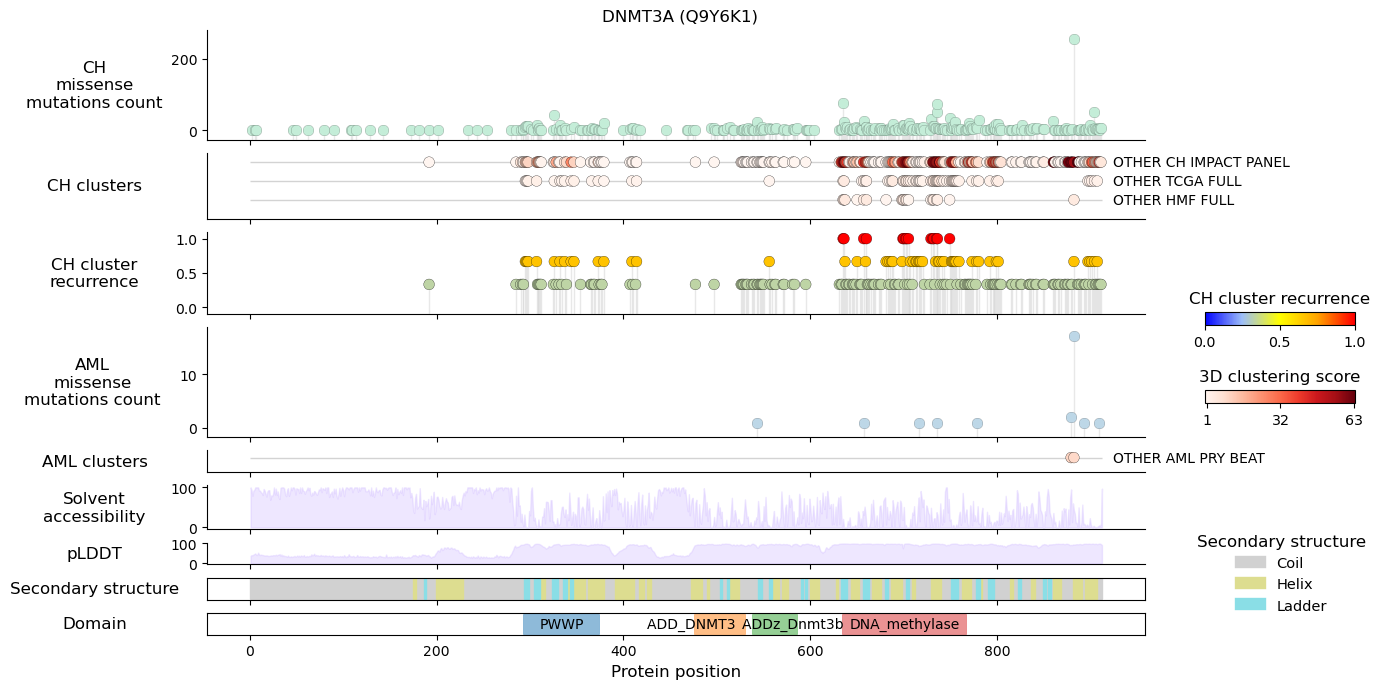

In [36]:
gene = "DNMT3A"
o3d_gene_dict = o3d_dict[gene] 
    
if gene not in o3d_seq_df.Gene.values:
    cohort_1 = list(o3d_gene_dict.keys())[0]
    o3d_seq_df_gene = f"{o3d_ch_output_dir}/{cohort_1}/{cohort_1}.seq_df.processed.tsv"
    o3d_seq_df_gene = pd.read_table(o3d_seq_df_gene)
else:
    o3d_seq_df_gene = o3d_seq_df.copy()

uni_id, tr_id = o3d_seq_df_gene.loc[o3d_seq_df_gene["Gene"] == gene, ["Uniprot_ID", "Ens_Transcr_ID"]].values[0]
pdb_tool_gene = o3d_pdb_tool_df[o3d_pdb_tool_df["Uniprot_ID"] == uni_id].reset_index(drop=True)
domain_gene = o3d_annot_df[(o3d_annot_df["Gene"] == gene) & 
                           (o3d_annot_df["Type"] == "DOMAIN") & 
                           (o3d_annot_df["Evidence"] == "Pfam")].reset_index(drop=True)
disorder_gene = disorder_df[disorder_df["Uniprot_ID"] == uni_id].reset_index(drop=True)
if gene in ["EGFR", "ERBB2"]:
    domain_gene.Description = domain_gene.Description.replace("GF_recep_IV", "GF_recep_IV      ")
    domain_gene.Description = domain_gene.Description.replace("TM_ErbB1", "   TM_ErbB1")
if gene in ["DNMT3A"]:
    domain_gene.Description = domain_gene.Description.replace("ADD_DNMT3", "ADD_DNMT3             ")
    domain_gene.Description = domain_gene.Description.replace("ADDz_Dnmt3b", "        ADDz_Dnmt3b")
domain_gene = None if len(domain_gene) == 0 else domain_gene

cohort_df_gene = cohort_all_ch_df[cohort_all_ch_df.COHORT.isin(o3d_gene_dict.keys())]

if len(cohort_df_gene.GENERAL_CANCER_TYPE.unique()) == 1:
    cohort_df_gene = cohort_all_df[cohort_all_df.COHORT.isin(o3d_gene_dict.keys())]    
    cohort_df_gene["ORDER"] = cohort_df_gene.apply(lambda x: 2 if x.GENERAL_CANCER_TYPE == "CH" else 1 if x.GENERAL_CANCER_TYPE == "MYELOID" else 0, axis=1)
    cohort_df_gene["MAX_SCORE"] = [o3d_gene_dict[cohort]["Result"].Score_obs_sim.max() for cohort in cohort_df_gene.COHORT]
    cohort_df_gene = cohort_df_gene.sort_values(["ORDER", "GENERAL_CANCER_TYPE", "CANCER_TYPE", "MAX_SCORE"], ascending=[True, True, True, False]).reset_index(drop=True)
else:
    cohort_df_gene["MAX_SCORE"] = [o3d_gene_dict[cohort]["Result"].Score_obs_sim.max() for cohort in cohort_df_gene.COHORT]
    cohort_df_gene = cohort_df_gene.sort_values(["GENERAL_CANCER_TYPE", "MAX_SCORE"], ascending=[True, True]).reset_index(drop=True)

o3d_gene_dict = {k: v for k, v in o3d_gene_dict.items() if k in cohort_df_gene.COHORT.values}
missense_gene_df = missense_df[missense_df.Cohort.isin(o3d_gene_dict.keys())]
missense_gene_df = missense_gene_df.groupby(['Gene', 'Pos']).size().reset_index(name='Count')
missense_gene_df = missense_gene_df[missense_gene_df["Gene"] == gene]
missense_gene_ch_df = missense_count_ch_df[missense_count_ch_df["Gene"] == gene]

if show_degron:
    degmd_gene = degmd_pred[degmd_pred["Entry"] == uni_id].reset_index(drop=True)
    if len(degmd_gene) == 0:
        uni_id_canonical, tr_id_canonical = o3d_seq_df_canonical.loc[o3d_seq_df_canonical["Gene"] == gene, ["Uniprot_ID", "Ens_Transcr_ID"]].values[0]
        if tr_id_canonical == tr_id:
            degmd_gene = degmd_pred[degmd_pred["Entry"] == uni_id_canonical].reset_index(drop=True)
            if annotated_deg:
                degmd_gene = degmd_gene[degmd_gene.Annotated == "YES"]
                degmd_gene.DEGRON = degmd_gene.DEGRON.str.replace(" \(K\)", "")
    else:
        if gene in ["NFE2L2"]:
            degmd_gene.DEGRON = degmd_gene.DEGRON.replace("DEG_Kelch_Keap1_1", "       Kelch_Keap1_1")
            degmd_gene.DEGRON = degmd_gene.DEGRON.replace("DEG_Kelch_Keap1_2", "Kelch_Keap1_2       ")
        if annotated_deg:
            degmd_gene = degmd_gene[degmd_gene.Annotated == "YES"]
            degmd_gene.DEGRON = degmd_gene.DEGRON.str.replace(" \(K\)", "")
else:
    degmd_gene = pd.DataFrame(columns=['DEGRON'])

gene_conservation_df = plot_cluster_conservation_ch(o3d_gene_dict,
                                                   missense_gene_df,
                                                   missense_gene_ch_df,
                                                   domain_gene, 
                                                   degmd_gene,
                                                   disorder_gene,
                                                   pdb_tool_gene,
                                                   cohort_df_gene,
                                                   gene,
                                                   plot_pars,
                                                   o3d_seq_df_gene,
                                                   title=f"{gene} ({uni_id})",
                                                   absolute_score=True,
                                                   extend_clusters=True,
                                                   return_conservation_df=True)

/tmp/ipykernel_3588908/2574366984.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cohort_df_gene["MAX_SCORE"] = [o3d_gene_dict[cohort]["Result"].Score_obs_sim.max() for cohort in cohort_df_gene.COHORT]


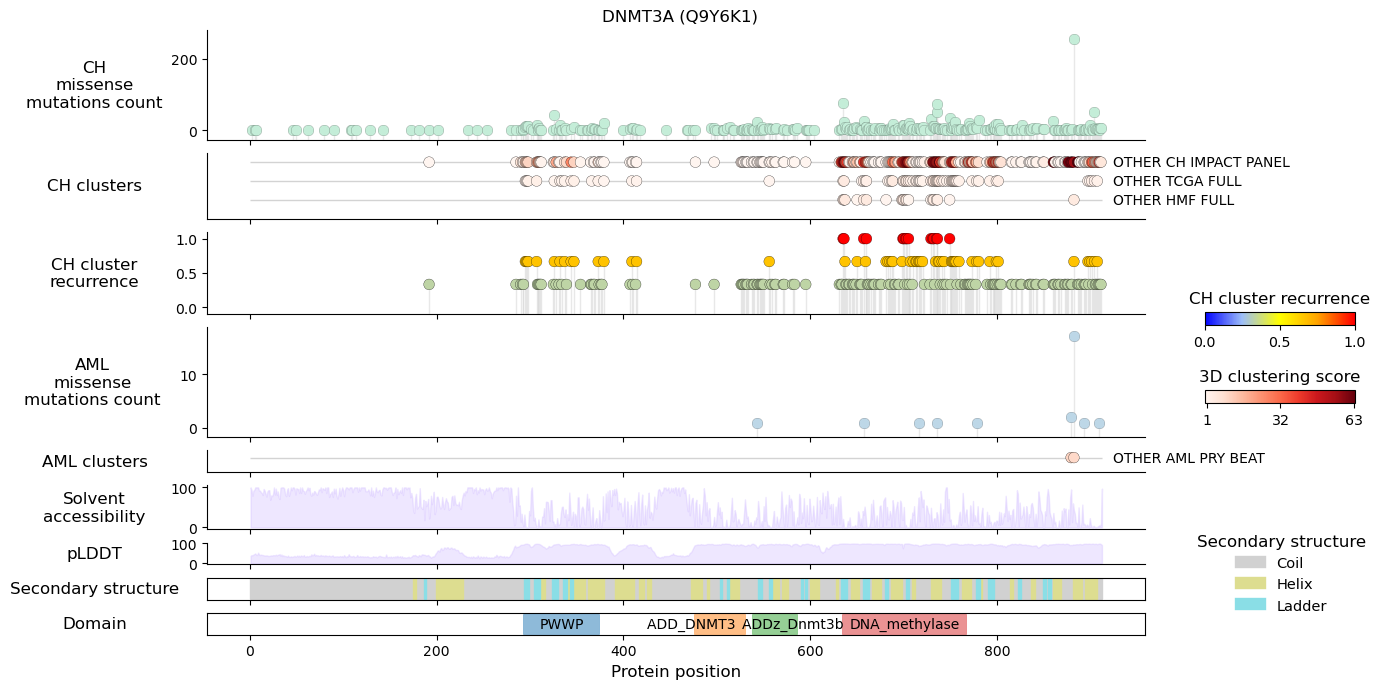

/tmp/ipykernel_3588908/2574366984.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cohort_df_gene["MAX_SCORE"] = [o3d_gene_dict[cohort]["Result"].Score_obs_sim.max() for cohort in cohort_df_gene.COHORT]


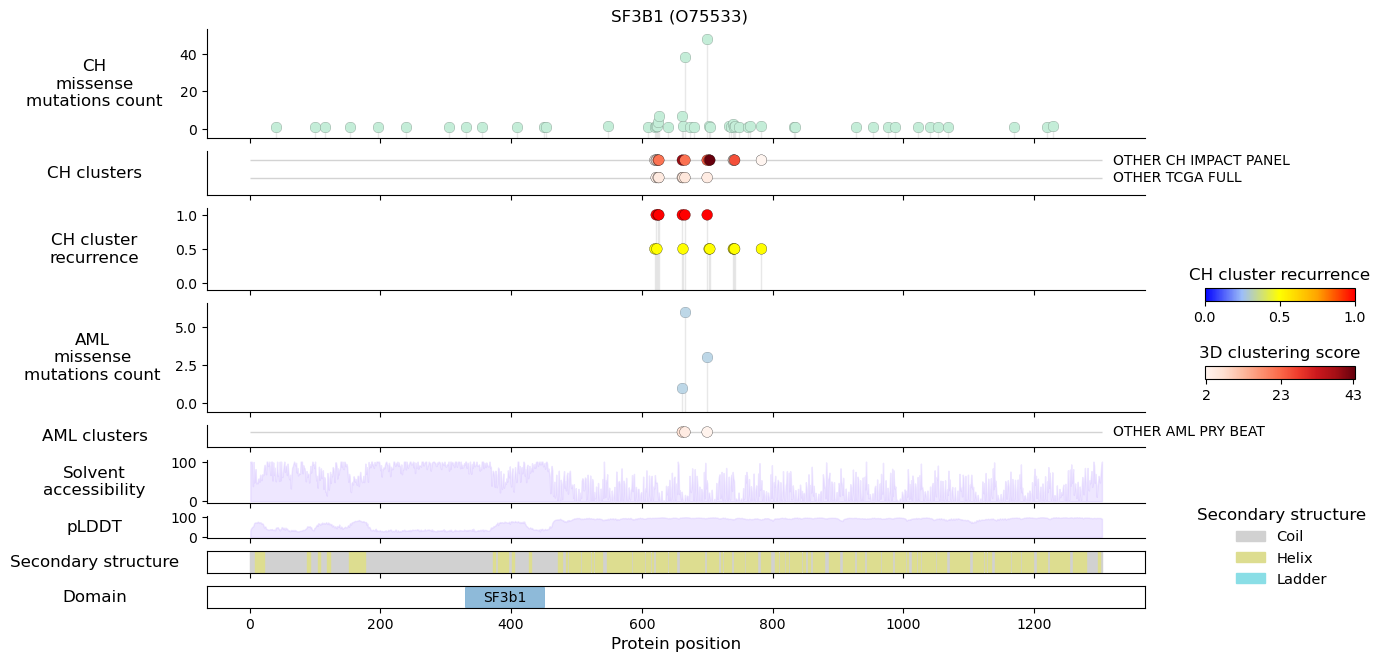

Gene, Uniprot ID tuple for cluster conservation: [('DNMT3A', 'Q9Y6K1'), ('SF3B1', 'O75533')]


In [37]:
genes_cluster_conservation = ["DNMT3A", "SF3B1"]
uni_id_cluster_conservation = []

for gene in ["DNMT3A", "SF3B1"]:

    o3d_gene_dict = o3d_dict[gene] 
    
    if gene not in o3d_seq_df.Gene.values:
        cohort_1 = list(o3d_gene_dict.keys())[0]
        o3d_seq_df_gene = f"{o3d_ch_output_dir}/{cohort_1}/{cohort_1}.seq_df.processed.tsv"
        o3d_seq_df_gene = pd.read_table(o3d_seq_df_gene)
    else:
        o3d_seq_df_gene = o3d_seq_df.copy()

    uni_id, tr_id = o3d_seq_df_gene.loc[o3d_seq_df_gene["Gene"] == gene, ["Uniprot_ID", "Ens_Transcr_ID"]].values[0]
    pdb_tool_gene = o3d_pdb_tool_df[o3d_pdb_tool_df["Uniprot_ID"] == uni_id].reset_index(drop=True)
    domain_gene = o3d_annot_df[(o3d_annot_df["Gene"] == gene) & 
                               (o3d_annot_df["Type"] == "DOMAIN") & 
                               (o3d_annot_df["Evidence"] == "Pfam")].reset_index(drop=True)
    disorder_gene = disorder_df[disorder_df["Uniprot_ID"] == uni_id].reset_index(drop=True)
    if gene in ["EGFR", "ERBB2"]:
        domain_gene.Description = domain_gene.Description.replace("GF_recep_IV", "GF_recep_IV      ")
        domain_gene.Description = domain_gene.Description.replace("TM_ErbB1", "   TM_ErbB1")
    if gene in ["DNMT3A"]:
        domain_gene.Description = domain_gene.Description.replace("ADD_DNMT3", "ADD_DNMT3             ")
        domain_gene.Description = domain_gene.Description.replace("ADDz_Dnmt3b", "        ADDz_Dnmt3b")
    
    cohort_df_gene = cohort_all_ch_df[cohort_all_ch_df.COHORT.isin(o3d_gene_dict.keys())]

    if len(cohort_df_gene.GENERAL_CANCER_TYPE.unique()) == 1:
        cohort_df_gene = cohort_all_df[cohort_all_df.COHORT.isin(o3d_gene_dict.keys())]    
        cohort_df_gene["ORDER"] = cohort_df_gene.apply(lambda x: 2 if x.GENERAL_CANCER_TYPE == "CH" else 1 if x.GENERAL_CANCER_TYPE == "MYELOID" else 0, axis=1)
        cohort_df_gene["MAX_SCORE"] = [o3d_gene_dict[cohort]["Result"].Score_obs_sim.max() for cohort in cohort_df_gene.COHORT]
        cohort_df_gene = cohort_df_gene.sort_values(["ORDER", "GENERAL_CANCER_TYPE", "CANCER_TYPE", "MAX_SCORE"], ascending=[True, True, True, False]).reset_index(drop=True)
    
    else:
        cohort_df_gene["MAX_SCORE"] = [o3d_gene_dict[cohort]["Result"].Score_obs_sim.max() for cohort in cohort_df_gene.COHORT]
        cohort_df_gene = cohort_df_gene.sort_values(["GENERAL_CANCER_TYPE", "MAX_SCORE"], ascending=[True, True]).reset_index(drop=True)

    o3d_gene_dict = {k: v for k, v in o3d_gene_dict.items() if k in cohort_df_gene.COHORT.values}
    missense_gene_df = missense_df[missense_df.Cohort.isin(o3d_gene_dict.keys())]
    missense_gene_df = missense_gene_df.groupby(['Gene', 'Pos']).size().reset_index(name='Count')
    missense_gene_df = missense_gene_df[missense_gene_df["Gene"] == gene]
    missense_gene_ch_df = missense_count_ch_df[missense_count_ch_df["Gene"] == gene]

    if gene in genes_cluster_conservation or gene in genes_order[genes_order > 4].index:
        filename = f"../../figures_and_tables/supplementary/s12/s12.{gene}_ch_recurrence.png"
    else:
        filename = None
        
    gene_conservation_df = plot_cluster_conservation_ch(o3d_gene_dict,
                                                       missense_gene_df,
                                                       missense_gene_ch_df,
                                                       domain_gene, 
                                                       pd.DataFrame(columns=['DEGRON']),
                                                       disorder_gene,
                                                       pdb_tool_gene,
                                                       cohort_df_gene,
                                                       gene,
                                                       plot_pars,
                                                       o3d_seq_df_gene,
                                                       title=f"{gene} ({uni_id})",
                                                       absolute_score=True,
                                                       extend_clusters=True,
                                                       return_conservation_df=True,
                                                       filename=filename)

    if gene in genes_cluster_conservation and sum(cohort_df_gene.GENERAL_CANCER_TYPE == "CH") > 1:
        attr_file_path = f"data/ch/{gene}.ch_clusters_conservation.defattr"
        write_defattr_file(attr_file_path, gene, uni_id, gene_conservation_df)
        uni_id_cluster_conservation.append((gene, uni_id))

print("Gene, Uniprot ID tuple for cluster conservation:", uni_id_cluster_conservation)

# ChimeraX plots script

In [38]:
## Example to generate ChimeraX plot

# open ~AF-Q9Y6K1-F1-model_v4.pdb
# color gray
# set bgColor white

# open ~SF3B1.ch_clusters_conservation.defattr
# #color byattribute Conservation palette ^esmfold
# color byattribute Conservation palette 0,#0000FF:0.25,#6495ED:0.5,#FFFF00:0.75,#FFA500:1,#FF0000

# style sphere
# sel :541,542,545,546
# hide sel cartoons
# show sel atoms

# ~select
# lighting full
# graphics silhouettes false
# zoom

# save ~../../figures_and_tables/main/f6/f6.SF3B1_structure.png width 4000 height 3000 supersample 3 transparentBackground true